# Business Context

TopBank is a European banking services company, which offers financial products such as bank accounts, investment products and some types of insurance through physical agencies and an online portal. The company's main product is an ordinary bank account, in which customers can make deposits, withdrawals, and transfers.


- **Business Model:** The account is free of charge for the customer for the first 12 months as a trial period, after which, if the customer renews the service for another 12 months, a fee will be charged at the end of this period proportional to the customer's salary. The amount charged varies between 15% to 20% of the client's monthly salary. If the client's salary is lower than the average salary, the fee is 15% of the monthly salary, otherwise the fee is 20%.


- **Business Problem:** In the last few months, the number of customers canceling their accounts has been increasing, as has the company's churn rate.


- **Main Goal:** Create a high-performance prevention model to identify the probability of a customer going into churn. 


- **Secundary Goal:** Create a report on the performance and results of the model by answering the following questions::
    1. What is the current Churn rate of TopBank? How does it vary monthly if the data allows this analysis?
    2. How well does the model perform in classifying customers as churn?
    3. What is the company's revenue if it prevents customers from churning through the model?
    4. Considering a financial incentive for customers to renew for 12 more months, with a maximum of R$10,000.00 in total for all incentives. Which customers should receive the incentive and what is the value of this incentive for each customer to maximize ROI?

# 0.0. Imports

In [67]:
# data manipulation
import numpy as np
import pandas as pd
import inflection

# stratifiel sampling
from sklearn import model_selection as ms

# statistics
from scipy.stats import chi2_contingency

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# statistics
from scipy.stats import chi2_contingency, pointbiserialr

# load images
from IPython.display import Image

# data preparation
from sklearn.preprocessing import MinMaxScaler, RobustScaler, LabelEncoder, LabelBinarizer, OrdinalEncoder
from imblearn import combine as comb

# machine learning models
from sklearn.ensemble import RandomForestClassifier

# model evaluation
from sklearn.metrics import log_loss, brier_score_loss, accuracy_score, precision_score,\
                            recall_score, roc_auc_score, f1_score, ConfusionMatrixDisplay

# warning
import warnings
warnings.filterwarnings( 'ignore' )

## 0.1. Auxiliar Functions

In [2]:
def cramer_v(x, y):
    # simple cross tabulation
    cm = pd.crosstab(x, y).values
    
    # number of observations
    n = cm.sum()
    
    # number of rows and columns
    r, k = cm.shape
    
    # phi coefficient
    chi2 = chi2_contingency(cm)[0]
    
    # correction of phi coefficient
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    # number of rows and columns correction
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt((chi2corr/n)/(min(kcorr-1, rcorr-1)))

## 0.2. Load Data

- Data source: https://www.kaggle.com/datasets/mervetorkan/churndataset

In [3]:
data_raw = pd.read_csv('../datasets/churn.csv')

# convert camel case to snake case
data_raw.columns = [inflection.underscore(cols) for cols in data_raw.columns]

# data sample
data_raw.sample(10)

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
1934,1935,15584930,Grimmett,726,Germany,Male,30,5,111375.32,2,1,0,2704.09,0
3378,3379,15571302,Estep,529,Germany,Male,72,5,94216.05,1,1,1,78695.68,0
8379,8380,15745266,Norman,434,Spain,Male,55,6,0.00,1,0,1,73562.05,1
9784,9785,15687626,Zhirov,527,France,Male,39,4,0.00,2,1,0,167183.07,1
1251,1252,15814930,McGregor,588,Germany,Female,40,10,125534.51,1,1,0,121504.18,1
484,485,15676519,George,615,Spain,Male,61,9,0.00,2,1,0,150227.85,1
1088,1089,15645517,Philip,850,Spain,Male,22,2,0.00,2,1,1,9684.52,0
6752,6753,15605424,Oluchukwu,624,Spain,Male,38,7,123906.55,1,1,0,135096.78,0
840,841,15707567,Esposito,732,Germany,Male,50,6,145338.76,1,0,0,91936.10,1
23,24,15725737,Mosman,669,France,Male,46,3,0.00,2,0,1,8487.75,0


## 0.3. Split Data into Training and Test

In [4]:
data_train, data_test = ms.train_test_split(data_raw, test_size=0.2, random_state=42)

# 1.0. Data Description

In [5]:
df01 = data_train.copy()

## 1.1. Features Description

- **RowNumber:** The column number;
- **CustomerID:** Unique identifier of the customer;
- **Surname:** Last name of the customer;
- **CreditScore:** The customer's Credit Score for the consumer market;
- **Geography:** The country where the customer resides;
- **Gender:** The customer's gender;
- **Age:** The customer's age;
- **Tenure:** Number of years that the customer has been active;
- **Balance:** Monetary value that the customer has in his bank account;
- **NumOfProducts:** The number of products bought by the customer in the bank;
- **HasCrCard:** Indicates whether or not the client has a credit card;
- **IsActiveMember:** Indicates if the client has made at least one transaction in the bank account within the last 12 months;
- **EstimatedSalary:** Indicates the client's estimated monthly salary;
- **Exited:** Indicates whether or not the customer is in churn;

## 1.2. Data Types

In [6]:
df01.dtypes

row_number            int64
customer_id           int64
surname              object
credit_score          int64
geography            object
gender               object
age                   int64
tenure                int64
balance             float64
num_of_products       int64
has_cr_card           int64
is_active_member      int64
estimated_salary    float64
exited                int64
dtype: object

## 1.3. Data Dimensions

In [7]:
print(f'Number of Rows: {df01.shape[0]}')
print(f'Number of Columns: {df01.shape[1]}')

Number of Rows: 8000
Number of Columns: 14


- Relatively small database

## 1.4. Check NA

In [8]:
df01.isna().sum()

row_number          0
customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

## 1.5. Fillout NA

There is no NA in the dataset

## 1.6. Change Data Types

In [9]:
# convert customer id to string
df01['customer_id'] = df01['customer_id'].astype(object)

## 1.7. Check Balance Data

In [10]:
df01['exited'].value_counts(normalize=True)

0    0.7945
1    0.2055
Name: exited, dtype: float64

Unbalanced dataset with 80/20 of the data for the negative and positive classes, respectively.

## 1.8. Descriptive Analysis

In [11]:
# select numeric attributes
num_attributes = df01[['credit_score', 'age', 'tenure', 'balance', 
                       'num_of_products', 'estimated_salary', 'exited']]

# select categorical and binary attributes
cat_attributes = df01[['surname', 'geography', 'gender', 'has_cr_card', 
                       'is_active_member', 'exited']]

### 1.8.1. Numerical Attributes

In [12]:
# central tendency - mean, median
mean = pd.DataFrame(num_attributes.apply(np.mean)).T
median = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion tendency - std, min, max, range, skew, kurtosis
std = pd.DataFrame(num_attributes.apply(np.std)).T
min_ = pd.DataFrame(num_attributes.apply(min)).T
max_ = pd.DataFrame(num_attributes.apply(max)).T
range_ = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
skew = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
kurtosis = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# join dataframes
num_stats = pd.concat([min_, max_, range_, mean, median, skew, kurtosis]).T.reset_index()
num_stats.columns = ['attributes', 'min',  'max', 'range', 'mean', 'median', 'skew', 'kurtosis']

# display numerical analysis
num_stats

,attributes,min,max,range,mean,median,skew,kurtosis
0,credit_score,350.00,850.00,500.00,651.647625,653.00,-0.082577,-0.412964
1,age,18.00,92.00,74.00,38.897750,37.00,1.004232,1.322109
2,tenure,0.00,10.00,10.00,5.003875,5.00,0.015093,-1.150506
3,balance,0.00,250898.09,250898.09,76102.139645,96447.52,-0.129407,-1.493190
4,num_of_products,1.00,4.00,3.00,1.531375,1.00,0.721139,0.502987
5,estimated_salary,90.07,199970.74,199880.67,100431.289764,100487.72,-0.004443,-1.180224
6,exited,0.00,1.00,1.00,0.205500,0.00,1.457954,0.125662


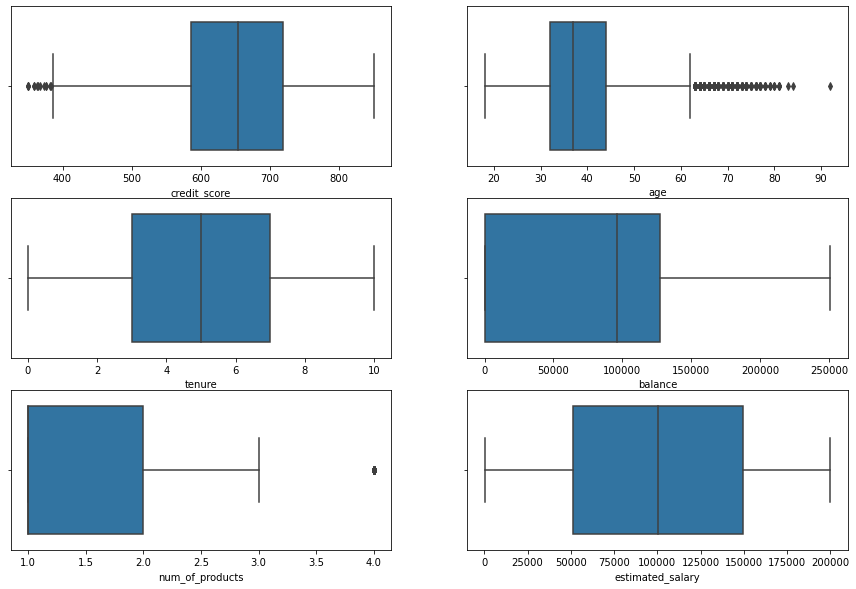

In [13]:
# checking outliers
plt.figure(figsize=(15,10))

# credit score
plt.subplot(3, 2, 1)
sns.boxplot(x='credit_score', data=num_attributes);

# age
plt.subplot(3, 2, 2)
sns.boxplot(x='age', data=num_attributes);

# tenure
plt.subplot(3, 2, 3)
sns.boxplot(x='tenure', data=num_attributes);

# balance
plt.subplot(3, 2, 4)
sns.boxplot(x='balance', data=num_attributes);

# num ofucts
plt.subplot(3, 2, 5)
sns.boxplot(x='num_of_products', data=num_attributes);

# estimated salary
plt.subplot(3, 2, 6)
sns.boxplot(x='estimated_salary', data=num_attributes);

- _credit_score_, _tenure_, _estimated_salary_ have a skew close to zero.

- Large amount of customer with _balance_ equal to zero.

- _estimated_salary_ shows a below-average minimum, it is probably a system error.

- _estimated_salary_ shows no outliers.

- Dataset has people with 0 years of permanence in the bank (_tenure_ = 0), it can indicate people who have not yet completed a year as a client.

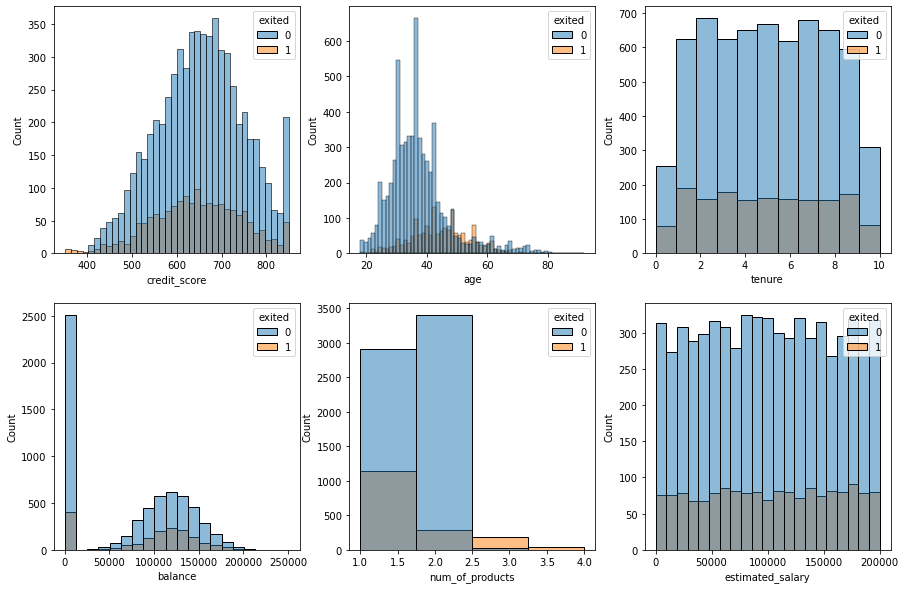

In [14]:
# checking distribuitions for both classes
plt.figure(figsize=(15,10))

# credit score
plt.subplot(2,3,1)
sns.histplot(data=df01, x='credit_score', hue='exited');

# age
plt.subplot(2,3,2)
sns.histplot(data=df01, x='age', hue='exited');

# tenure
plt.subplot(2,3,3)
sns.histplot(data=df01, x='tenure', hue='exited', bins=11);

# balance
plt.subplot(2,3,4)
sns.histplot(data=df01, x='balance', hue='exited');

# num_of_products
plt.subplot(2,3,5)
sns.histplot(data=df01, x='num_of_products', hue='exited', bins=4, common_norm=True);

# estimated_salary
plt.subplot(2,3,6)
sns.histplot(data=df01, x='estimated_salary', hue='exited');

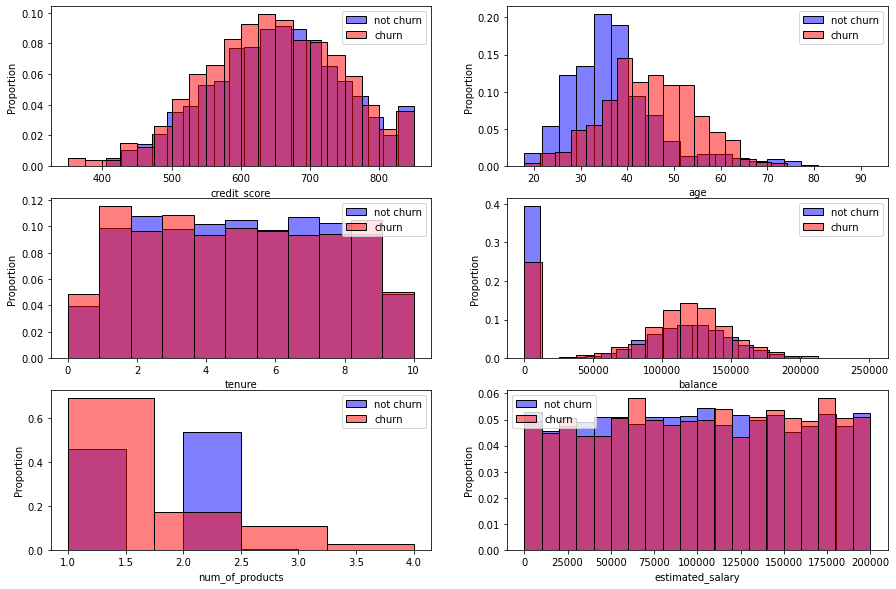

In [15]:
# checking distribuitions of numerical attributes for both classes
plt.figure(figsize=(15,10))


# credit_score
plt.subplot(3,2,1)
sns.histplot(data=df01[df01['exited'] == 0], x='credit_score', bins=20, stat='proportion', color='b', alpha=0.5);
sns.histplot(data=df01[df01['exited'] == 1], x='credit_score', bins=20, stat='proportion', color='r', alpha=0.5);
plt.legend(labels=['not churn', 'churn']);

# age
plt.subplot(3,2,2)
sns.histplot(data=df01[df01['exited'] == 0], x='age', bins=20, stat='proportion', color='b', alpha=0.5);
sns.histplot(data=df01[df01['exited'] == 1], x='age', bins=20, stat='proportion', color='r', alpha=0.5);
plt.legend(labels=['not churn', 'churn']);

# tenure
plt.subplot(3,2,3)
sns.histplot(data=df01[df01['exited'] == 0], x='tenure', bins=11, stat='proportion', color='b', alpha=0.5);
sns.histplot(data=df01[df01['exited'] == 1], x='tenure', bins=11, stat='proportion', color='r', alpha=0.5);
plt.legend(labels=['not churn', 'churn']);

# balance
plt.subplot(3,2,4)
sns.histplot(data=df01[df01['exited'] == 0], x='balance', bins=20, stat='proportion', color='b', alpha=0.5);
sns.histplot(data=df01[df01['exited'] == 1], x='balance', bins=20, stat='proportion', color='r', alpha=0.5);
plt.legend(labels=['not churn', 'churn']);

# num_of_products
plt.subplot(3,2,5)
sns.histplot(data=df01[df01['exited'] == 0], x='num_of_products', bins=4, stat='proportion', color='b', alpha=0.5);
sns.histplot(data=df01[df01['exited'] == 1], x='num_of_products', bins=4, stat='proportion', color='r', alpha=0.5);
plt.legend(labels=['not churn', 'churn']);

# estimated_salary
plt.subplot(3,2,6)
sns.histplot(data=df01[df01['exited'] == 0], x='estimated_salary', bins=20, stat='proportion', color='b', alpha=0.5);
sns.histplot(data=df01[df01['exited'] == 1], x='estimated_salary', bins=20, stat='proportion', color='r', alpha=0.5);
plt.legend(labels=['not churn', 'churn']);

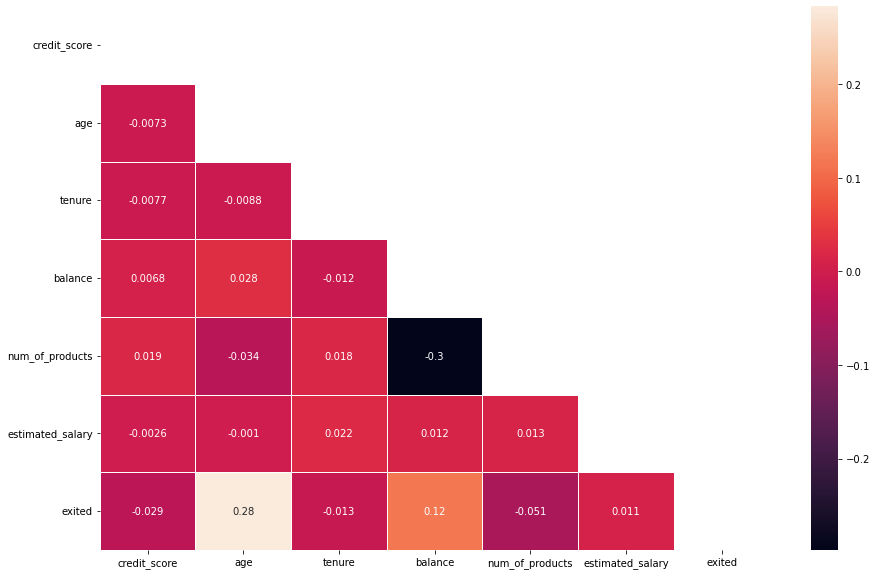

In [16]:
# calculate correlations by pearson
num_corr = num_attributes.corr(method='pearson')

# mask to only show values from below
mask = np.triu(np.ones_like(num_corr, dtype=np.bool_))

# plot heatmap
plt.figure(figsize=(15,10))
sns.heatmap(num_corr, mask=mask, linewidths=0.5, annot=True);

- one can see a churn separation starting at the age of 40 or so.
- After 3 products the churn rate drops a lot.
- balance with a value of zero has a high relationship with churn but may be a system error.

### 1.8.2. Categorical Attributes

In [17]:
cat_attributes.astype(object).describe()

,surname,geography,gender,has_cr_card,is_active_member,exited
count,8000,8000,8000,8000,8000,8000
unique,2618,3,2,2,2,2
top,Shih,France,Male,1,1,0
freq,24,3994,4362,5628,4102,6356


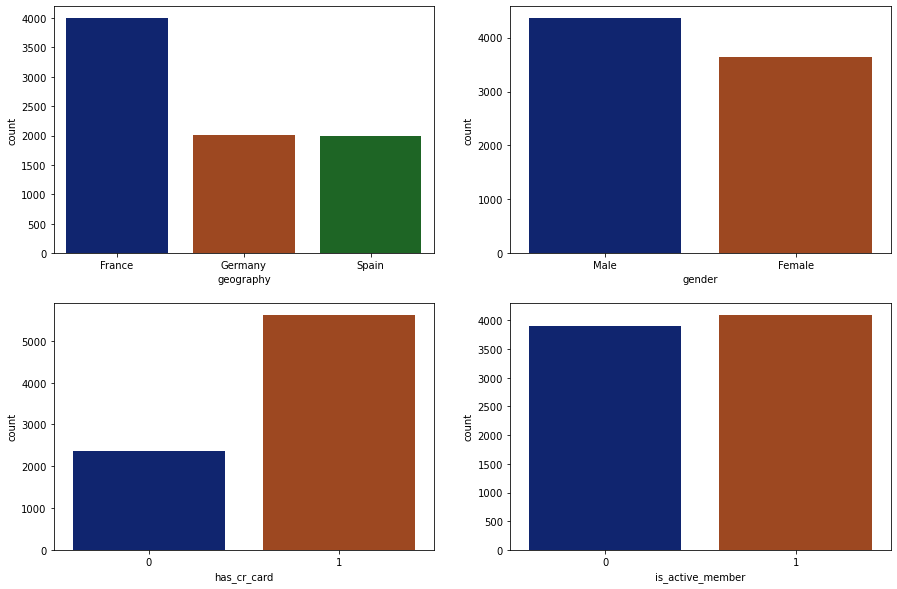

In [18]:
# checking balance of categorical data
plt.figure(figsize=(15,10))

# geography
plt.subplot(2,2,1)
sns.countplot(x='geography', data=cat_attributes, palette='dark');

# gender 
plt.subplot(2,2,2)
sns.countplot(x='gender', data=cat_attributes, palette='dark');

# has_cr_card 
plt.subplot(2,2,3)
sns.countplot(x='has_cr_card', data=cat_attributes, palette='dark');

# is_active_member 
plt.subplot(2,2,4)
sns.countplot(x='is_active_member', data=cat_attributes, palette='dark');

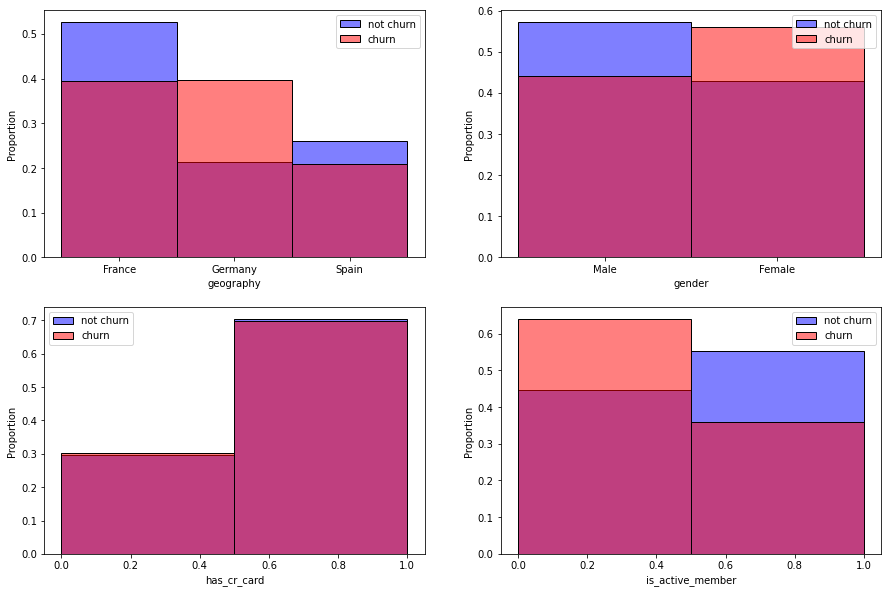

In [19]:
# checking distribuitions of numerical attributes for both classes
plt.figure(figsize=(15,10))

# geography
plt.subplot(2,2,1)
sns.histplot(data=df01[df01['exited'] == 0], x='geography', bins=3, stat='proportion', color='b', alpha=0.5);
sns.histplot(data=df01[df01['exited'] == 1], x='geography', bins=3, stat='proportion', color='r', alpha=0.5);
plt.legend(labels=['not churn', 'churn']);

# gender 
plt.subplot(2,2,2)
sns.histplot(data=df01[df01['exited'] == 0], x='gender', bins=2, stat='proportion', color='b', alpha=0.5);
sns.histplot(data=df01[df01['exited'] == 1], x='gender', bins=2, stat='proportion', color='r', alpha=0.5);
plt.legend(labels=['not churn', 'churn']);

#has_cr_card 
plt.subplot(2,2,3)
sns.histplot(data=df01[df01['exited'] == 0], x='has_cr_card', bins=2, stat='proportion', color='b', alpha=0.5);
sns.histplot(data=df01[df01['exited'] == 1], x='has_cr_card', bins=2, stat='proportion', color='r', alpha=0.5);
plt.legend(labels=['not churn', 'churn']);

# is_active_member
plt.subplot(2,2,4)
sns.histplot(data=df01[df01['exited'] == 0], x='is_active_member', bins=2, stat='proportion', color='b', alpha=0.5);
sns.histplot(data=df01[df01['exited'] == 1], x='is_active_member', bins=2, stat='proportion', color='r', alpha=0.5);
plt.legend(labels=['not churn', 'churn']);

- Germany proves to be a country with a high churn rate;
- There is a clear separation of churn rates by gender
- Being an active member influences the churn rate.

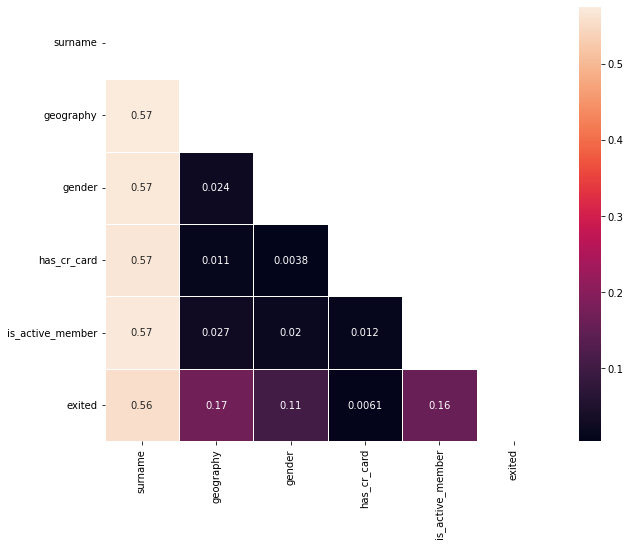

In [20]:
cat_columns = cat_attributes.columns.tolist()

corr_dict = {}

for main_cols in cat_columns:
    corr_list = []
    
    for secundary_cols in cat_columns:
        #cramer v
        cat_corr = cramer_v(cat_attributes[main_cols], cat_attributes[secundary_cols])
        
        # add to list
        corr_list.append(cat_corr)
    
    # add to dict each attribute correlation
    corr_dict[main_cols] = corr_list
    
df_corr = pd.DataFrame(corr_dict)
df_corr = df_corr.set_index(df_corr.columns)

# mask to only show values from below
mask = np.triu(np.ones_like(df_corr, dtype=np.bool_))

# plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df_corr, mask=mask, linewidths=0.5, annot=True);

- There are no repeated users in the database.
- Almost half of the dataset is located in France.
- Just over half of the database is an active member.
- Database has similar numbers by gender.
- Only 3 countries present in the dataset: France, Germany and Spain.

# 2.0. Feature Engineering

In [21]:
df02 = df01.copy()

## 2.1. Features Mind Map

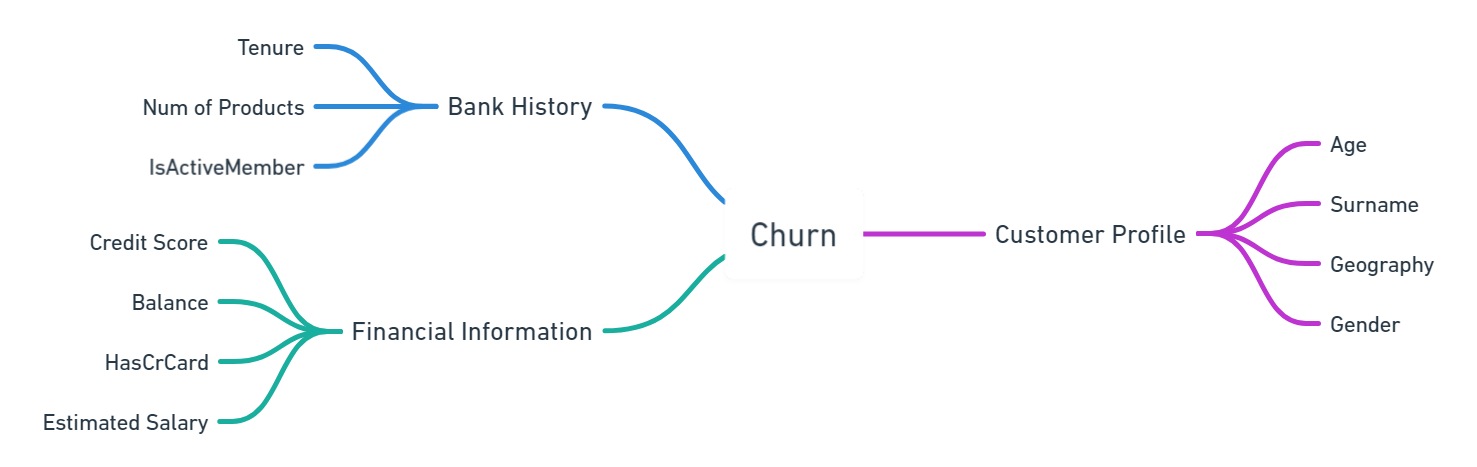

In [22]:
Image('../images/churn-predictions-mindmap.png')

## 2.2. List of Hypothesis

### 2.2.1. Customer Profile Hypothesis

1. Both genders have similar churn rates (+/-5%).

2. Customers under the age of 40 commit 50% more churns than others, on average.

3. 30% of customers from the same family (same surname) cancel their accounts together.

4. The more customers a country has, the lower the churn rate (pearson coefficient > 0.25).

### 2.2.2. Bank History Hypothesis

1. Customers with more than 5 years of permanence have a 40% lower churn rate.

2. Active members have a 50% lower churn rate than others.

3. The greater the quantity of products, the lower the churn rate (pearson coefficient > 0.4).

4. The churn rate during the trial month is 30% higher.

5. The higher the annual fee, the higher the churn rate (pearson coefficient > 0.60).

6. The higher the total payment to the bank, the higher the churn rate (pearson coefficient > 0.10).

### 2.2.3. Financial Information Hypothesis

1. Customers with a null balance commit 40% more churns than the others, on average.

2. Credit card customers have a 30% lower churn rate than other customers.

3. The lower the customers' credit score, the higher the churn rate (pearson coefficient > 0.2).

4. The higher the customer salary spend, the lower the churn rate (pearson coefficient > 0.3).

5. High-wage earners commit 25% fewer churns, on average.

## 2.3. Final Hypothesis List

1. Both genders have similar churn rates (+/-5%).

2. Customers under the age of 40 commit 50% more churns than others, on average.

3. 30% of customers from the same family (same surname) cancel their accounts together.

4. The more customers a country has, the lower the churn rate (pearson coefficient > 0.25).

5. Customers with more than 5 years of permanence have a 40% lower churn rate.

6. Active members have a 50% lower churn rate than others.

7. The greater the quantity of products, the lower the churn rate (pearson coefficient > 0.4).

8. The churn rate during the trial month is 30% higher.

9. The higher the annual fee, the higher the churn rate (pearson coefficient > 0.60).

10. The higher the total payment to the bank, the higher the churn rate (pearson coefficient > 0.10).

11. Customers with a null balance commit 40% more churns than the others, on average.

12. Credit card customers have a 30% lower churn rate than other customers.

13. The lower the customers' credit score, the higher the churn rate (pearson coefficient > 0.2).

14. The higher the customer salary spend, the lower the churn rate (pearson coefficient > 0.3).

15. High-wage earners commit 25% fewer churns, on average.

## 2.4. Feature Engineering

In [23]:
# total of churns per surnameame
df02['exited_surname_sum'] = df02[['surname', 'exited']].apply(lambda x: df02[df02['surname'] == x['surname']]['exited'].sum(), 
                                                               axis=1)

#  average churn per surname
df02['exited_surname_mean'] = df02[['surname', 'exited']].apply(lambda x: df02[df02['surname'] == x['surname']]['exited'].mean(), 
                                                                axis=1)

# number of family members
df02['household_size'] = df02['surname'].apply(lambda x: df02[df02['surname'] == x]['surname'].count())

# balance nulo
df02['balance_null'] = np.where(df02['balance'] == 0, 1, 0)

# total amount
df02['total_amount'] = df02['estimated_salary'] + df02['balance']

# total spent
df02['total_spent'] = df02['estimated_salary'] - df02['balance']

# categorical salary (average from countries)
df02['salary_type'] = df02['estimated_salary'].apply(lambda x: 'low' if x <= 50000 
                                                       else 'medium' if x <= 100000 
                                                       else 'above'  if x <= 150000 
                                                       else 'well_above')

# users in free trial
df02['free_trial'] = np.where(df02['tenure'] == 0, 1, 0)

# annual payment for the bank
df02['annual_fee'] = df02['estimated_salary'].apply(lambda x: x*(0.15/12) if x <= df02['estimated_salary'].mean() else 
                                                              x*(0.20/12))

# total payment for the bank
df02['total_fee'] = df02[['annual_fee', 'tenure', 'free_trial']].apply(lambda x: 0 if x['free_trial'] == 1 else 
                                                                                 x['annual_fee']*(x['tenure']-1), 
                                                                       axis=1)

# reorder data columns
df02 = df02[['row_number', 'customer_id', 'surname', 'exited_surname_sum', 'exited_surname_mean', 
             'household_size', 'credit_score', 'geography', 'gender', 'age', 'tenure', 'free_trial', 
             'balance', 'balance_null', 'num_of_products', 'has_cr_card','is_active_member', 
             'estimated_salary', 'total_amount', 'total_spent', 'salary_type', 'annual_fee', 
             'total_fee', 'exited']]

# 3.0. Data Filtering

In [24]:
df03 = df02.copy()

## 3.1. Filtering Rows

- No line filtering seems to be necessary according to the analysis done so far.

## 3.2. Columns Selection

- _row_number_, _customer_id_ are removed from the dataset as they do not carry information of value for learning the models.

In [25]:
df03 = df03.drop(columns=['row_number', 'customer_id'])

# 4.0. Exploratory Data Analysis

In [26]:
df04 = df03.copy()

In [27]:
num_attributes = df04.select_dtypes(include=['int64', 'float64'])

cat_attributes = df04.select_dtypes(include=['object'])

## 4.1. Univariate Analysis

### 4.1.1. Target Variable

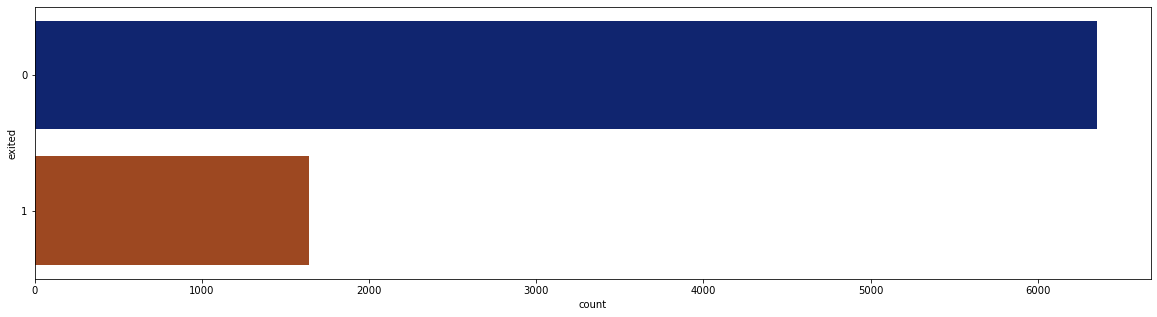

In [28]:
# checking balance of categorical data
plt.figure(figsize=(20,5))

# exited
sns.countplot(y=df04['exited'], palette='dark');

### 4.1.1. Numerical Variables

#### 4.1.1.1. Credit Score

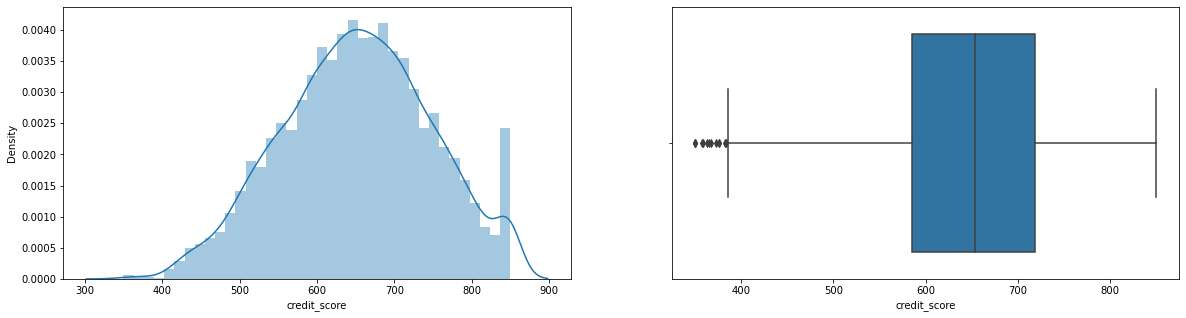

In [29]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
sns.distplot(num_attributes['credit_score']);

plt.subplot(1,2,2)
sns.boxplot(x='credit_score', data=num_attributes);

#### 4.1.1.2. Age

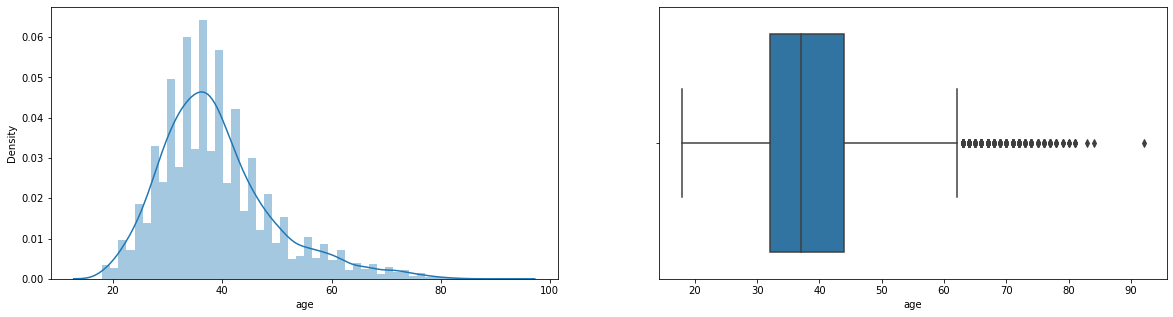

In [30]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
sns.distplot(df04['age']);

plt.subplot(1,2,2)
sns.boxplot(x='age', data=df04);

#### 4.1.1.3. Tenure

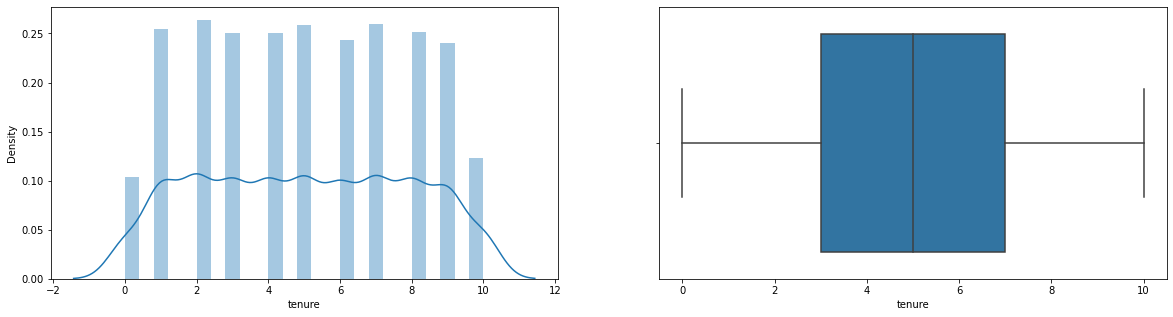

In [31]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
sns.distplot(df04['tenure']);

plt.subplot(1,2,2)
sns.boxplot(x='tenure', data=df04);

#### 4.1.1.4. Balance

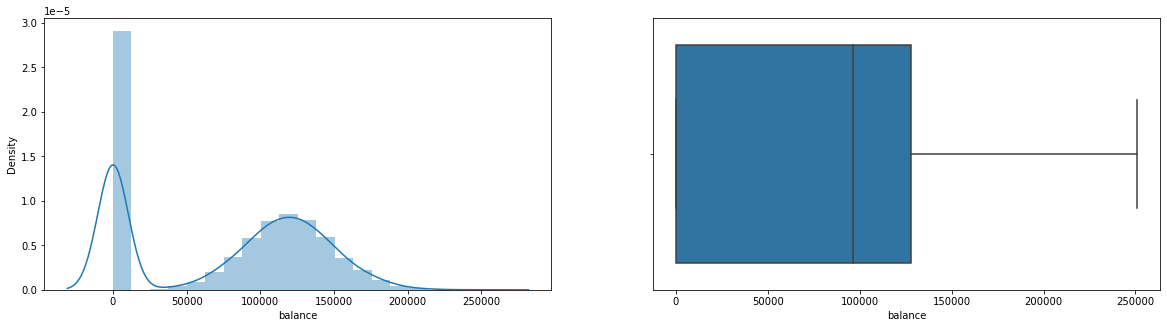

In [32]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
sns.distplot(df04['balance']);

plt.subplot(1,2,2)
sns.boxplot(x='balance', data=df04);

#### 4.1.1.5. Number of Products

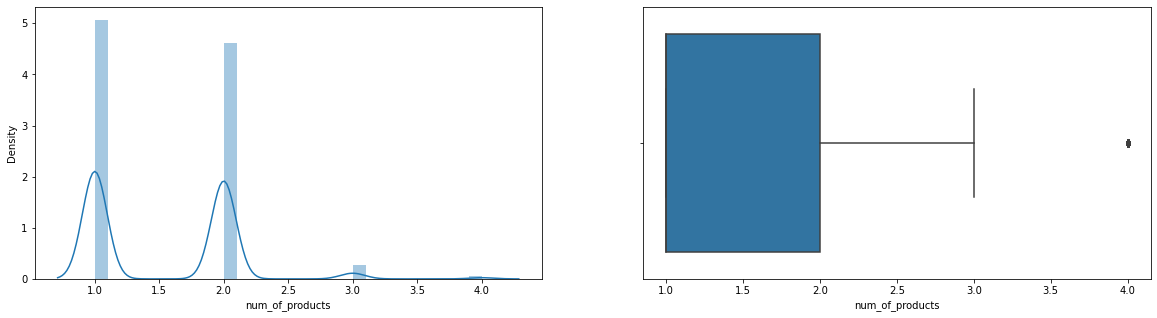

In [33]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
sns.distplot(df04['num_of_products']);

plt.subplot(1,2,2)
sns.boxplot(x='num_of_products', data=df04);

#### 4.1.1.6. Estimated Salary

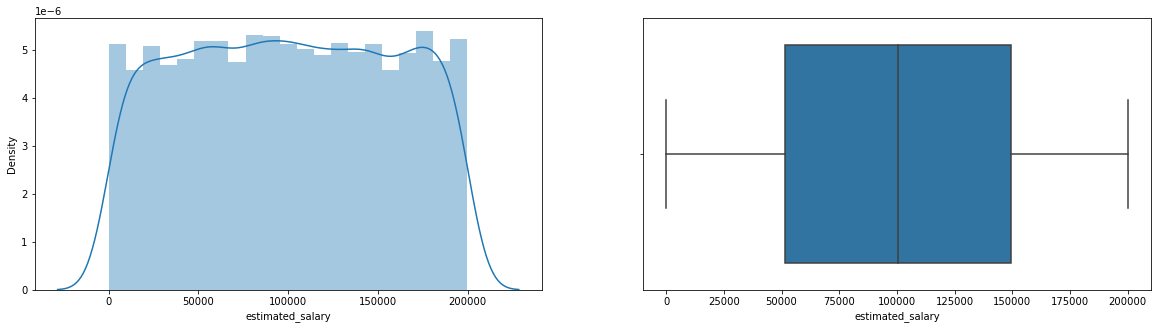

In [34]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
sns.distplot(df04['estimated_salary']);

plt.subplot(1,2,2)
sns.boxplot(x='estimated_salary', data=df04);

#### 4.1.1.7. Sum of Churns by Surname

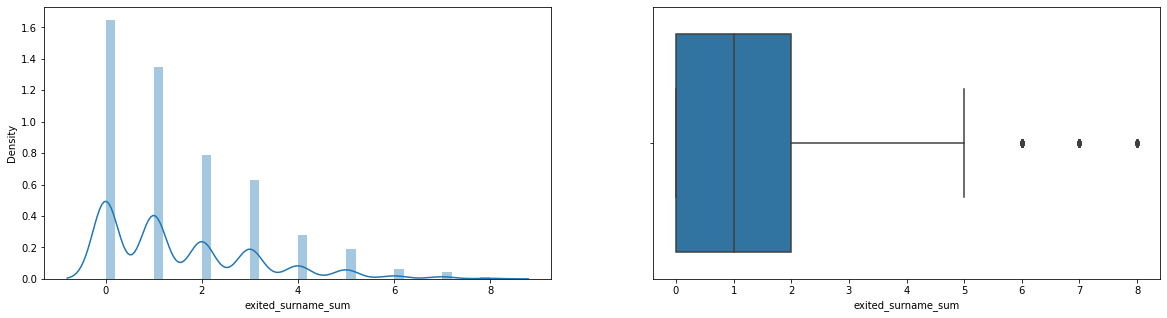

In [35]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
sns.distplot(df04['exited_surname_sum']);

plt.subplot(1,2,2)
sns.boxplot(x='exited_surname_sum', data=df04);

#### 4.1.1.8. Mean of Churns by Surname

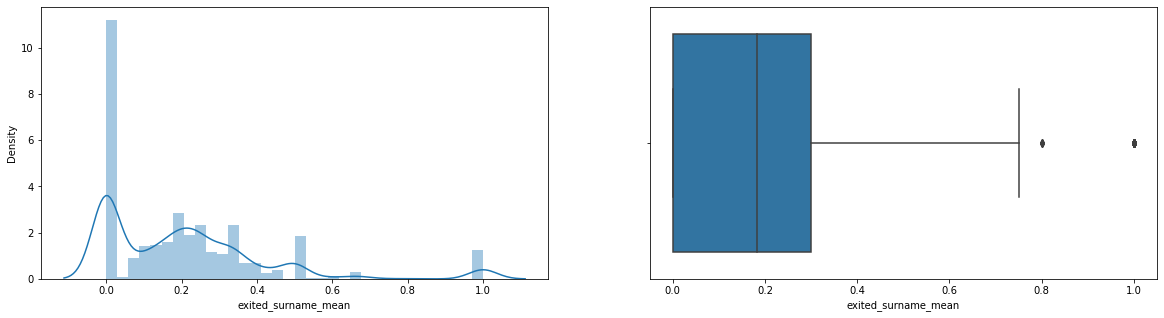

In [36]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
sns.distplot(df04['exited_surname_mean']);

plt.subplot(1,2,2)
sns.boxplot(x='exited_surname_mean', data=df04);

#### 4.1.1.9. Household Size

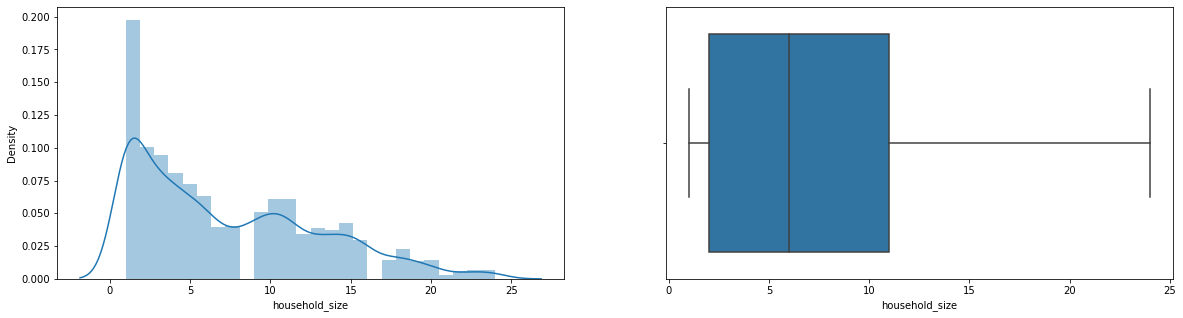

In [37]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
sns.distplot(df04['household_size']);

plt.subplot(1,2,2)
sns.boxplot(x='household_size', data=df04);

#### 4.1.1.10. Total Amount (Estimated Salary - Balance)

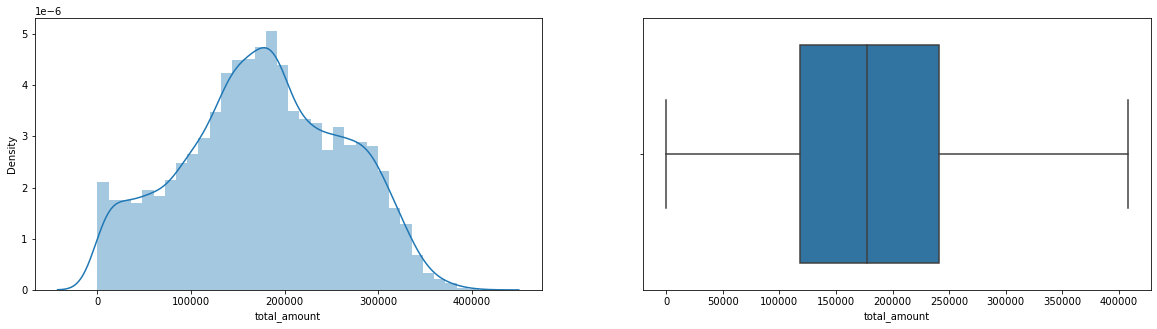

In [38]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
sns.distplot(df04['total_amount']);

plt.subplot(1,2,2)
sns.boxplot(x='total_amount', data=df04);

#### 4.1.1.11. Total Spending (Estimated Salary - Balance)

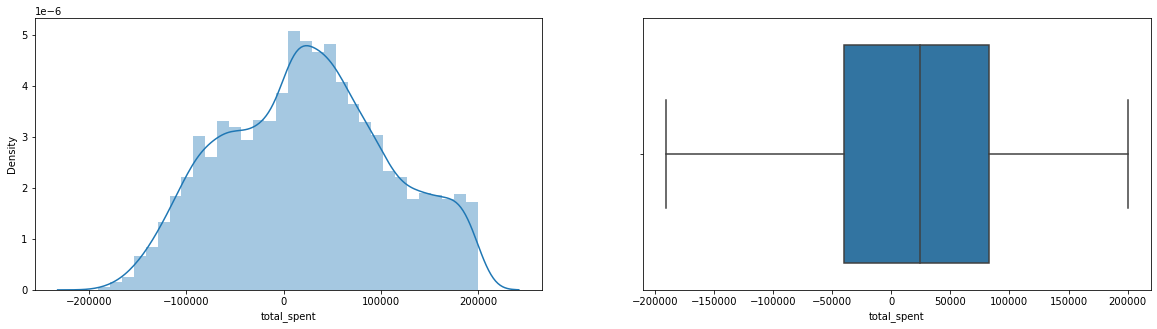

In [39]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
sns.distplot(df04['total_spent']);

plt.subplot(1,2,2)
sns.boxplot(x='total_spent', data=df04);

#### 4.1.1.12. Annual Fee

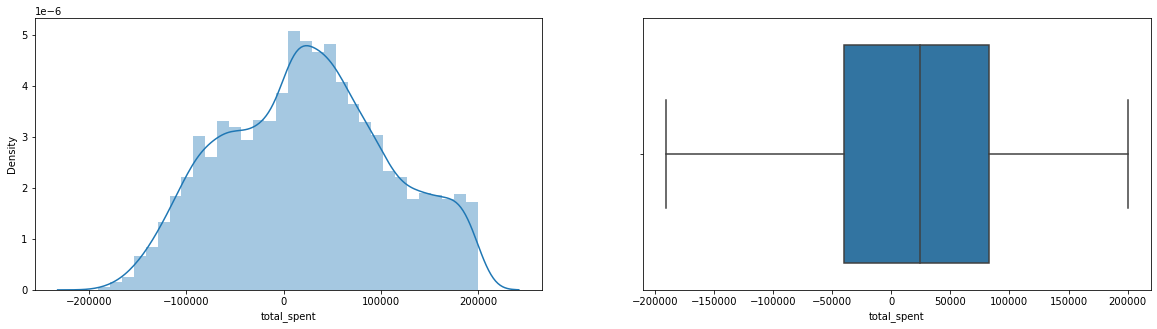

In [40]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
sns.distplot(df04['total_spent']);

plt.subplot(1,2,2)
sns.boxplot(x='total_spent', data=num_attributes);

#### 4.1.1.13. Total Fee

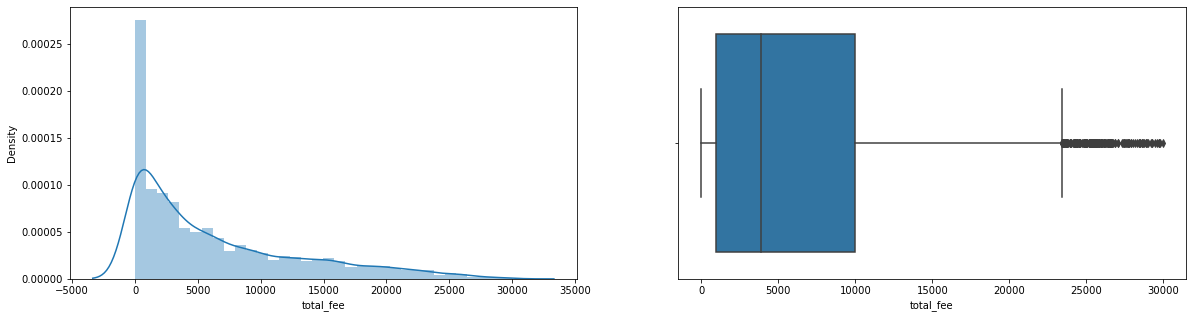

In [41]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
sns.distplot(df04['total_fee']);

plt.subplot(1,2,2)
sns.boxplot(x='total_fee', data=num_attributes);

### 4.1.2. Categorical Variables

#### 4.1.2.1. Original Features

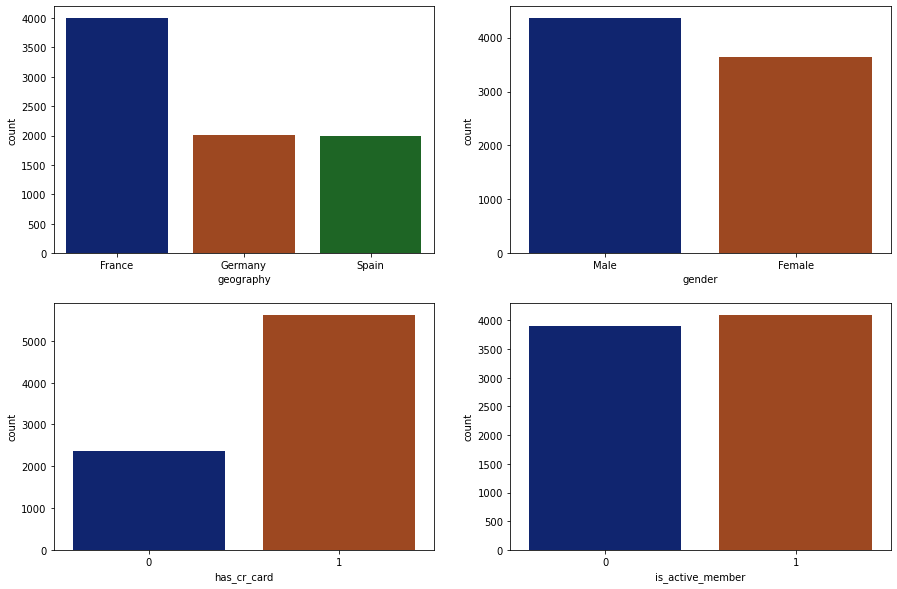

In [42]:
# checking balance of categorical data
plt.figure(figsize=(15,10))

# geography
plt.subplot(2,2,1)
sns.countplot(x=df04['geography'], palette='dark');

# gender 
plt.subplot(2,2,2)
sns.countplot(x=df04['gender'], palette='dark');

#has_cr_card 
plt.subplot(2,2,3)
sns.countplot(x=df04['has_cr_card'], palette='dark');

# is_active_member 
plt.subplot(2,2,4)
sns.countplot(x=df04['is_active_member'], palette='dark');

#### 4.1.2.2. Created Features

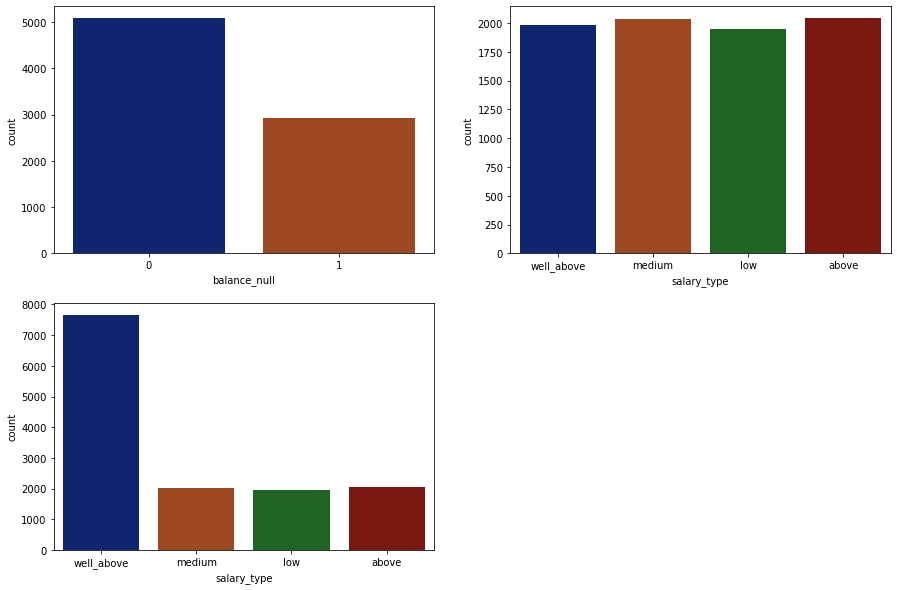

In [43]:
# setup figure size
plt.figure(figsize=(15,10))

# balance_null
plt.subplot(2, 2, 1)
sns.countplot(x=df04['balance_null'], palette='dark');

# gender
plt.subplot(2, 2, 2)
sns.countplot(x=df04['salary_type'], palette='dark');

# gender
plt.subplot(2, 2, 3)
sns.countplot(x=df04['free_trial'], palette='dark');

# salary_type
plt.subplot(2, 2, 3)
sns.countplot(x=df04['salary_type'], palette='dark');

## 4.2. Bivariate Analysis

### H1. Both genders have similar churn rates (+/-5%).
**FALSE:** Women have 47% higher churn rates than men.

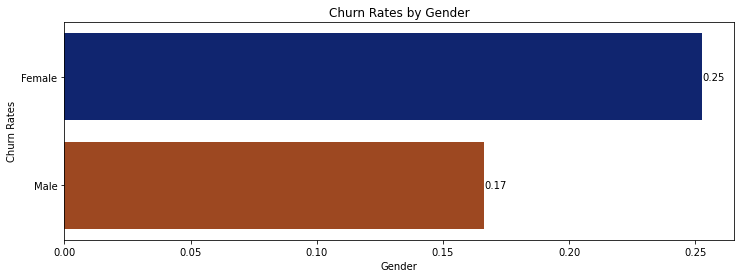

In [44]:
# mean of churn by gender
aux = df04[['gender', 'exited']].groupby('gender').mean().reset_index()

# display graph
plt.figure(figsize=(12,4))
graph = sns.barplot(y='gender', x='exited', data=aux, palette='dark');
graph.bar_label(graph.containers[0], fmt='%.2f');
plt.xlabel('Gender');
plt.ylabel('Churn Rates');
plt.title('Churn Rates by Gender');

### H2. Customers under the age of 40 commit 50% more churns than others, on average.
**FALSE:** Customers under 40 have 3 times lower churn rates than older customers.

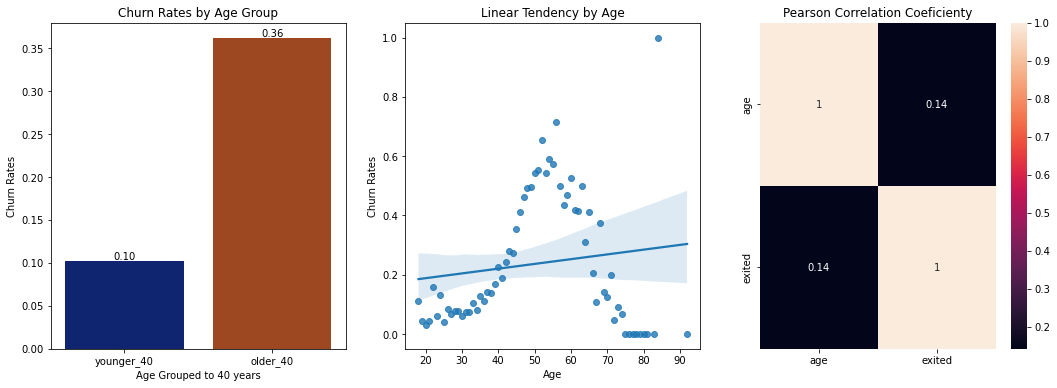

In [45]:
# select data of interest
aux = df04[['age', 'exited']].copy()

# create group for age
aux['age_group_40'] = np.where(aux['age'] < 40, 'younger_40', 'older_40')

# churn rate for age group
aux01 = aux[['age_group_40', 'exited']].groupby('age_group_40').mean().reset_index()

# display graph for age group
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
graph01 = sns.barplot(x='age_group_40', y='exited', data = aux01, 
                    order=['younger_40', 'older_40'], palette='dark')
graph01.bar_label(graph01.containers[0], fmt='%.2f');
plt.xlabel('Age Grouped to 40 years');
plt.ylabel('Churn Rates');
plt.title('Churn Rates by Age Group');

# churn rate by age
aux02 = df04[['age', 'exited']].groupby('age').mean().reset_index()

# display linear regression graph by age
plt.subplot(1,3,2)
graph02 = sns.regplot(x='age', y='exited', data=aux02)
plt.xlabel('Age');
plt.ylabel('Churn Rates');
plt.title('Linear Tendency by Age');

# pearson correlation coeficiente by age and churn
plt.subplot(1,3,3)
graph03 = sns.heatmap(aux02.corr(method='pearson'), annot=True)
plt.title('Pearson Correlation Coeficienty');

### H3. 30% of customers from the same family (same surname) cancel their accounts together.
**FALSE:** Only 2% of families churn together.

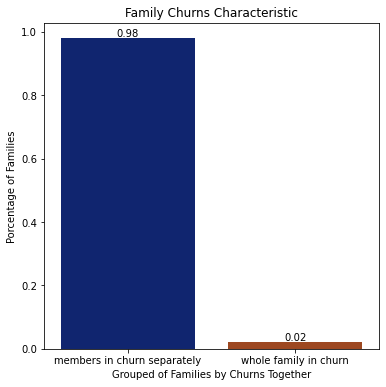

In [46]:
# select data of interest
aux = df04[(df04['household_size'] > 1) & (df04['exited_surname_sum'] > 0)]

# churn rate by families over 2 members
aux01 = aux[['surname', 'household_size', 'exited']].groupby(['surname', 'household_size']).mean().reset_index()

# grouped families by churn together and not
aux02 = aux01[['exited']].groupby(
    np.where(aux01['exited'] == 1, 'whole family in churn', 'members in churn separately' )
).count().reset_index().rename(columns={'index': 'family_churn'})

# porcentage of families than churn together
aux02['pct_family'] = np.round(aux02['exited'] / aux02['exited'].sum(), 2)

# display graph
plt.figure(figsize=(6,6))
graph = sns.barplot(x='family_churn', y='pct_family', data=aux02, palette='dark')
graph.bar_label(graph.containers[0], fmt='%.2f');
plt.xlabel('Grouped of Families by Churns Together');
plt.ylabel('Porcentage of Families');
plt.title('Family Churns Characteristic');

### H4. The more customers a country has, the lower the churn rate (pearson coefficient > 0.25).
**FALSE:** The more customers a country has, the lower the churn rates, with a Pearson correlation coefficient of -0.54. 

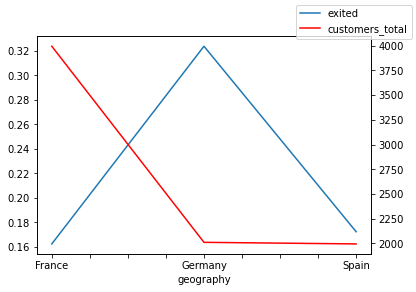

In [47]:
aux01 = df04[['geography', 'exited']].groupby(['geography']).mean().reset_index()
aux02 = df04[['geography']].groupby(['geography']).size().reset_index().rename(columns={0: 'customers_total'})

ax = aux01.plot(x="geography", y="exited", legend=False)

ax2 = ax.twinx()

aux02.plot(x="geography", y="customers_total", ax=ax2, legend=False, color="r")


ax.figure.legend()
plt.show()

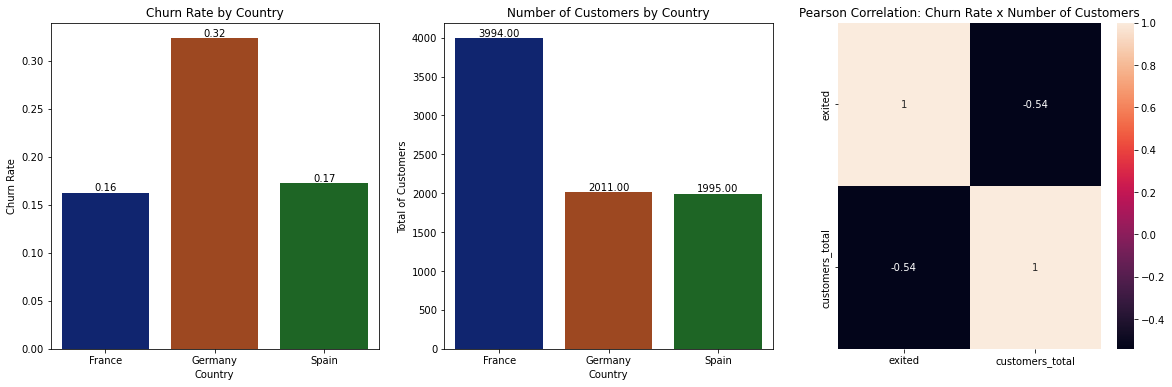

In [48]:
# churn rate by country 
aux01 = df04[['geography', 'exited']].groupby('geography').mean().reset_index()

# number of customers by country
aux02 = df04[['geography']].groupby(['geography']).size().reset_index().rename(columns={0: 'customers_total'})

# merge churn rate and number of customers
aux03 = pd.merge(aux01, aux02, on='geography', how='left')

# display churn rate by country graphs
plt.figure(figsize=(20,6))
plt.subplot(1, 3, 1)
graph01 = sns.barplot(x='geography', y='exited', data=aux03, palette='dark');
graph01.bar_label(graph01.containers[0], fmt='%.2f');
plt.xlabel('Country');
plt.ylabel('Churn Rate');
plt.title('Churn Rate by Country');

# display number of customers by country
plt.subplot(1, 3, 2)
graph02 = sns.barplot(x='geography', y='customers_total', data=aux03, palette='dark');
graph02.bar_label(graph02.containers[0], fmt='%.2f');
plt.xlabel('Country');
plt.ylabel('Total of Customers');
plt.title('Number of Customers by Country');

# display pearson correlation graph
plt.subplot(1, 3, 3)
sns.heatmap(aux03[['exited', 'customers_total']].corr(method='pearson'), annot=True);
plt.title('Pearson Correlation: Churn Rate x Number of Customers');

### H5. Customers with more than 5 years of permanence have a 40% lower churn rate.
**FALSE:** Both customers with more than 5 years and customers with less have similar churn rates.

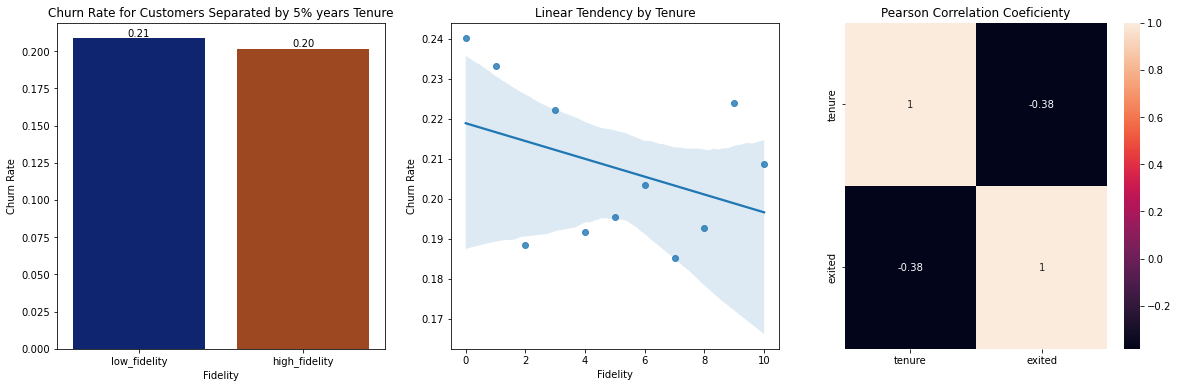

In [49]:
# grouped customers by tenure
aux01 = df04[['tenure', 'exited']].groupby(
    np.where(df04['tenure'] > 5, 'high_fidelity', 'low_fidelity')
).mean().reset_index().rename(columns={'index': 'fidelity'})

# display tenure group graph
plt.figure(figsize=(20,6))
plt.subplot(1, 3, 1)
graph01 = sns.barplot(x='fidelity', y='exited', data=aux01, palette='dark', 
                      order=['low_fidelity', 'high_fidelity'])
graph01.bar_label(graph01.containers[0], fmt='%.2f');
plt.xlabel('Fidelity');
plt.ylabel('Churn Rate');
plt.title('Churn Rate for Customers Separated by 5% years Tenure');

# churn rate by tenure
aux02 = df04[['tenure', 'exited']].groupby('tenure').mean().reset_index()

# display churn rate tendency graph
plt.subplot(1, 3, 2)
graph02 = sns.regplot(x='tenure', y='exited', data=aux02)
plt.xlabel('Fidelity');
plt.ylabel('Churn Rate');
plt.title('Linear Tendency by Tenure');

# display pearson correlation graph
plt.subplot(1, 3, 3)
graph03 = sns.heatmap(aux02.corr(method='pearson'), annot=True)
plt.title('Pearson Correlation Coeficienty');

### H6. Active members have a 50% lower churn rate than others.
**TRUE:** Active members have a 50% lower churn rate.

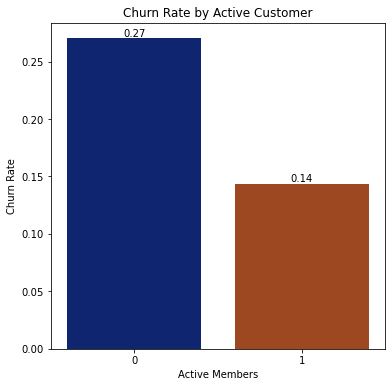

In [50]:
# churn rate by active members
aux01 = df04[['is_active_member', 'exited']].groupby('is_active_member').mean().reset_index()

# display churn rate graph
plt.figure(figsize=(6,6))
graph01 = sns.barplot(x='is_active_member', y='exited', data=aux01, palette='dark')
graph01.bar_label(graph01.containers[0], fmt='%.2f');
plt.xlabel('Active Members');
plt.ylabel('Churn Rate');
plt.title('Churn Rate by Active Customer');

### H7. The greater the quantity of products, the lower the churn rate (pearson coefficient > 0.4).
**FALSE:** The higher the quantity of products, the higher the churn rate with a pearson coefficient of 0.85.

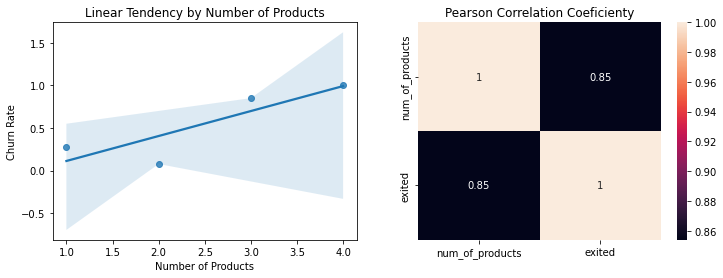

In [51]:
# churn rate by number of produtcs
aux01 = df04[['num_of_products', 'exited']].groupby('num_of_products').mean().reset_index()

# display churn rate by number of produts graph
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
graph01 = sns.regplot(x='num_of_products', y='exited', data=aux01)
plt.xlabel('Number of Products');
plt.ylabel('Churn Rate');
plt.title('Linear Tendency by Number of Products');

# display pearson correlation graph
plt.subplot(1,2,2)
sns.heatmap(aux01.corr(method='pearson'), annot=True)
plt.title('Pearson Correlation Coeficienty');

### H8. The churn rate during the trial month is 30% higher.
**FALSE:** The churn rate during the trial month is 20% higher.

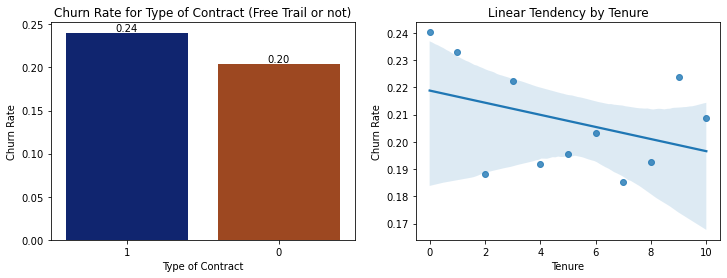

In [52]:
# churn rate by customers in and out of free trial
aux01 = df04[['free_trial', 'exited']].groupby('free_trial').mean().reset_index()

# display churn rate graph
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
graph01 = sns.barplot(x='free_trial', y='exited', data=aux01, order=[1, 0], palette='dark')
graph01.bar_label(graph01.containers[0], fmt='%.2f');
plt.xlabel('Type of Contract');
plt.ylabel('Churn Rate');
plt.title('Churn Rate for Type of Contract (Free Trail or not)');

# churn rate by tenure
aux02 = df04[['tenure', 'exited']].groupby('tenure').mean().reset_index()

# display linear tendency by tenure
plt.subplot(1,2,2)
graph02 = sns.regplot(x='tenure', y='exited', data=aux02)
plt.xlabel('Tenure');
plt.ylabel('Churn Rate');
plt.title('Linear Tendency by Tenure');

### H9: The higher the annual fee, the higher the churn rate (pearson coefficient > 0.60).
**FALSE:** The churn rate shows low correlation with the annual fee with a pearson coefficient of 0.1.

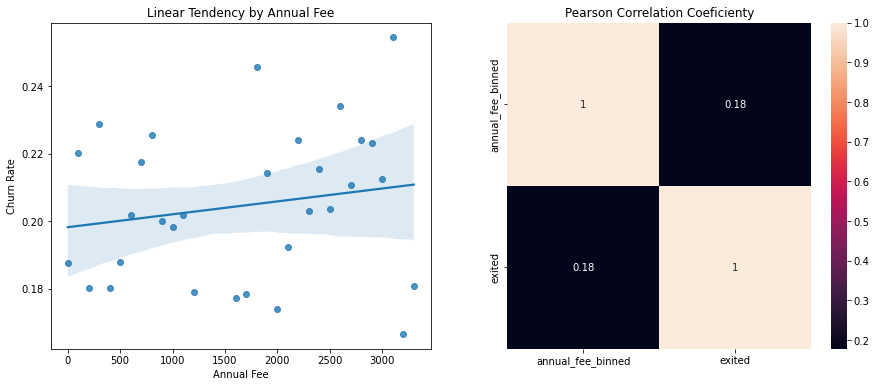

In [53]:
# select data of interest
aux = df04[['annual_fee', 'exited']].copy()

# churn rate for annual fee intervals
bins = list(np.arange(aux['annual_fee'].min(), aux['annual_fee'].max() + 100, 100))
aux['annual_fee_binned'] = pd.cut(aux['annual_fee'], bins=bins, right=False).apply(lambda x: x.left).astype(float)
aux01 = aux[['annual_fee_binned', 'exited']].groupby('annual_fee_binned').mean().reset_index()

# display linear tendency of churn rate by annual fee intervals graph
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.regplot(x='annual_fee_binned', y='exited', data=aux01)
plt.xlabel('Annual Fee');
plt.ylabel('Churn Rate');
plt.title('Linear Tendency by Annual Fee');

# display churn rate pearson coeficient by annual fee intervals graph
plt.subplot(1,2,2)
sns.heatmap(aux01.corr(method='pearson'), annot=True)
plt.title('Pearson Correlation Coeficienty');

### H10: The higher the total payment to the bank, the higher the churn rate (pearson coefficient > 0.10).
**FALSE:** The churn rate shows low correlation with the total payment with a pearson coefficient of -0.1.

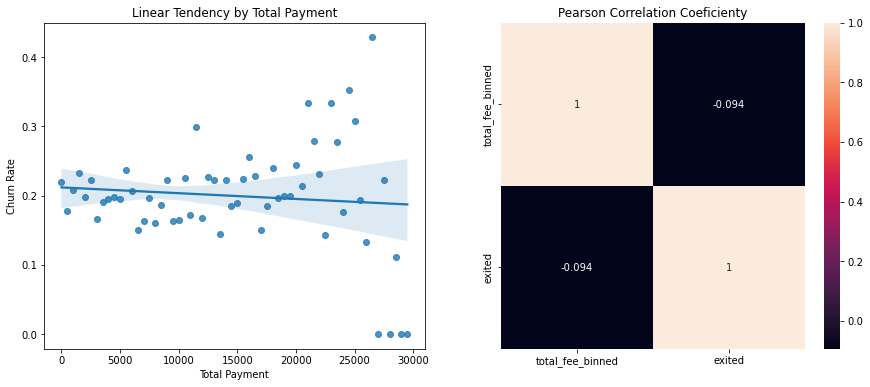

In [54]:
# select data of interest
aux = df04[['total_fee', 'exited']].copy()

# churn rate for annual fee intervals
bins = list(np.arange(aux['total_fee'].min(), aux['total_fee'].max() + 500, 500))
aux['total_fee_binned'] = pd.cut(aux['total_fee'], bins=bins, right=False).apply(lambda x: x.left).astype(float)
aux01 = aux[['total_fee_binned', 'exited']].groupby('total_fee_binned').mean().reset_index()

# display linear tendency of churn rate by total payment intervals graph
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.regplot(x='total_fee_binned', y='exited', data=aux01)
plt.xlabel('Total Payment');
plt.ylabel('Churn Rate');
plt.title('Linear Tendency by Total Payment');

# display churn rate pearson coeficient by total payment intervals graph
plt.subplot(1,2,2)
sns.heatmap(aux01.corr(method='pearson'), annot=True)
plt.title('Pearson Correlation Coeficienty');

### H11. Customers with a null balance commit 40% more churns than the others, on average.
**FALSE:** Customers with a null balance have 40% lower churn rate.

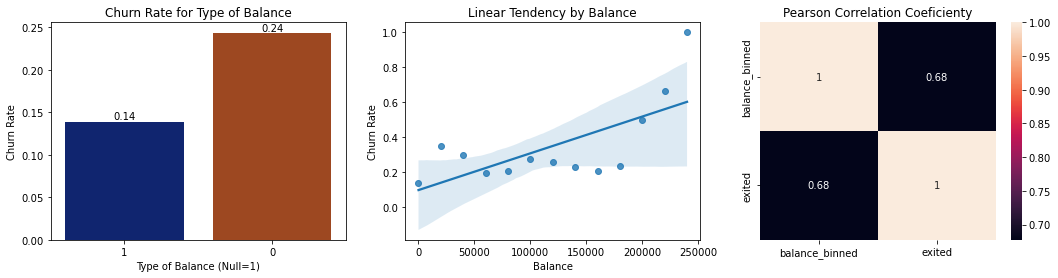

In [55]:
# select data of interest
aux = df04[['balance', 'exited']].copy()

# churn rate by balance null or not
aux01 = df04[['balance_null', 'exited']].groupby('balance_null').mean().reset_index()

# display churn rate by balance null or not graph
plt.figure(figsize=(18,4))
plt.subplot(1,3,1)
graph01 = sns.barplot(x='balance_null', y='exited', data=aux01, order=[1,0], palette='dark')
graph01.bar_label(graph01.containers[0], fmt='%.2f');
plt.xlabel('Type of Balance (Null=1)');
plt.ylabel('Churn Rate');
plt.title('Churn Rate for Type of Balance');

# churn rate for balance intervals
bins = list(np.arange(aux['balance'].min(), aux['balance'].max() + 20e3, 20e3))
aux['balance_binned'] = pd.cut(aux['balance'], bins=bins, right=False).apply(lambda x: x.left).astype(int)
aux02 = aux[['balance_binned', 'exited']].groupby('balance_binned').mean().reset_index()

# display linear tendency of churn rate by balance intervals graph
plt.subplot(1,3,2)
graph02 = sns.regplot(x='balance_binned', y='exited', data=aux02)
plt.xlabel('Balance');
plt.ylabel('Churn Rate');
plt.title('Linear Tendency by Balance');

# display churn rate pearson coeficient by balance intervals graph
plt.subplot(1,3,3)
graph03 = sns.heatmap(aux02.corr(method='pearson'), annot=True)
plt.title('Pearson Correlation Coeficienty');

### H12. Credit card customers have a 30% lower churn rate than other customers.
**FALSE:** Churn rates are similar between credit card and non-credit card customers.

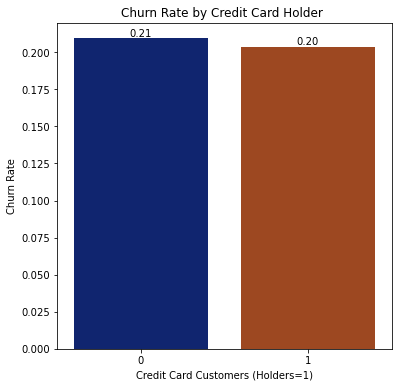

In [56]:
# churn rate by credit card holder 
aux01 = df04[['has_cr_card', 'exited']].groupby('has_cr_card').mean().reset_index()

# display churn rate graph
plt.figure(figsize=(6,6))
graph01 = sns.barplot(x='has_cr_card', y='exited', data=aux01, palette='dark')
graph01.bar_label(graph01.containers[0], fmt='%.2f');
plt.xlabel('Credit Card Customers (Holders=1)');
plt.ylabel('Churn Rate');
plt.title('Churn Rate by Credit Card Holder ');

### H13. The lower the customers' credit score, the higher the churn rate (pearson coefficient > 0.2).
**TRUE:** The lower the credit score, the higher the churn rate with a pearson coefficient of -0.54.

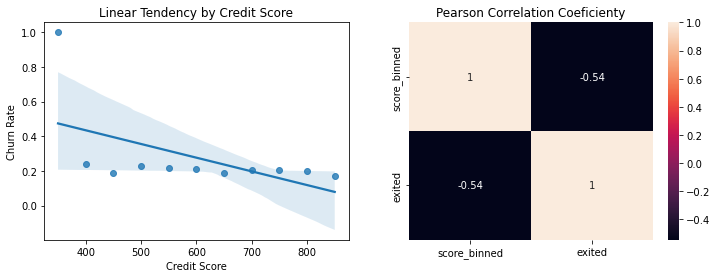

In [57]:
# select data of interest
aux = df04[['credit_score', 'exited']].copy()

# churn rate for credit score intervals
bins = list(np.arange(aux['credit_score'].min(), aux['credit_score'].max() + 51, 50))
aux['score_binned'] = pd.cut(aux['credit_score'], bins=bins, right=False).apply(lambda x: x.left).astype(int)
aux01 = aux[['score_binned', 'exited']].groupby('score_binned').mean().reset_index()

# display linear tendency by credit score intervals graph
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.regplot(x='score_binned', y='exited', data=aux01)
plt.xlabel('Credit Score');
plt.ylabel('Churn Rate');
plt.title('Linear Tendency by Credit Score');

# display churn rate pearson coeficient by credit score
plt.subplot(1,2,2)
sns.heatmap(aux01.corr(method='pearson'), annot=True)
plt.title('Pearson Correlation Coeficienty');

### H14. The higher the customer salary spend, the lower the churn rate (pearson coefficient > 0.3).
**FALSE:** The higher the customer spend, the lower the churn rate with a pearson coefficient of 0.88.

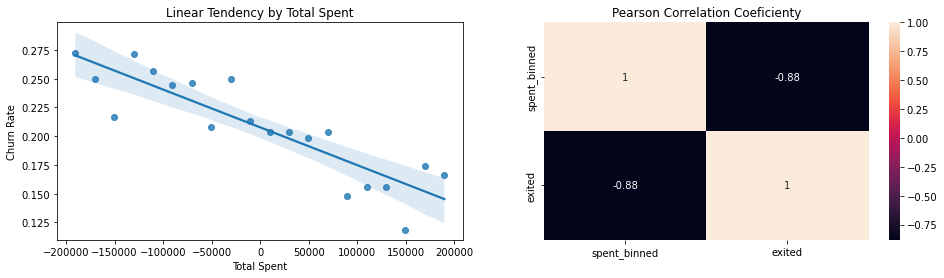

In [58]:
# churn rate by total spent
aux01 = df04[['total_spent', 'exited']].groupby('total_spent').mean().reset_index()

# select data of interest
aux = df04[['total_spent', 'exited']].copy()

# churn rate by total spent intervals
aux = df04[['total_spent', 'exited']].copy()
bins = list(np.arange(aux['total_spent'].min(), aux['total_spent'].max() + 20e3, 20e3))
aux['spent_binned'] = pd.cut(aux['total_spent'], bins=bins, right=False).apply(lambda x: x.left).astype(int)
aux02 = aux[['spent_binned', 'exited']].groupby('spent_binned').mean().reset_index()

# display linear tendency graph
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.regplot(x='spent_binned', y='exited', data=aux02)
plt.xlabel('Total Spent');
plt.ylabel('Churn Rate');
plt.title('Linear Tendency by Total Spent');

# display churn rate pearson coeficient by total spent
plt.subplot(1,2,2)
sns.heatmap(aux02.corr(method='pearson'), annot=True)
plt.title('Pearson Correlation Coeficienty');

### H15. High-wage earners commit 25% fewer churns, on average.
**FALSE:** The churn rate among customers of different salary ranges is the same.

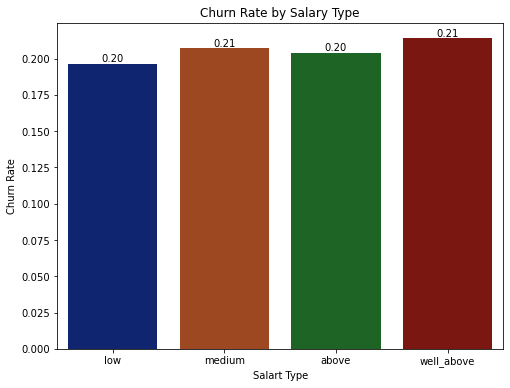

In [59]:
# churn rate by salary type
aux01 = df04[['salary_type', 'exited']].groupby('salary_type').mean().reset_index()

# displat churn rate graph
plt.figure(figsize=(8,6))
graph01 = sns.barplot(x='salary_type', y='exited', data=aux01, palette='dark', 
                     order=['low', 'medium', 'above', 'well_above'])
graph01.bar_label(graph01.containers[0], fmt='%.2f');
plt.xlabel('Salart Type');
plt.ylabel('Churn Rate');
plt.title('Churn Rate by Salary Type');

### 4.2.1. Hypotheses Summary

In [60]:
# hypothesis description
h1 = "Both genders have similar churn rates (+/-5%)."
h2 = "Customers under the age of 40 commit 50% more churns than others, on average."
h3 = "30% of customers from the same family (same surname) cancel their accounts together."
h4 = "The more customers a country has, the lower the churn rate (pearson coefficient > 0.25)."
h5 = "Customers with more than 5 years of permanence have a 40% lower churn rate."
h6 = "Active members have a 50% lower churn rate than others."
h7 = "The greater the quantity of products, the lower the churn rate (pearson coefficient > 0.4)."
h8 = "The churn rate during the trial month is 30% higher."
h9 = "The higher the annual fee, the higher the churn rate (pearson coefficient > 0.60)."
h10 = "The higher the total payment to the bank, the higher the churn rate (pearson coefficient > 0.10)."
h11 = "Customers with a null balance commit 40% more churns than the others, on average."
h12 = "Credit card customers have a 30% lower churn rate than other customers."
h13 = "The lower the customers' credit score, the higher the churn rate (pearson coefficient > 0.2)."
h14 = "The higher the customer salary spend, the lower the churn rate (pearson coefficient > 0.3)."
h15 = "High-wage earners commit 25% fewer churns, on average."

# hypothesis results
hip_tab = {'ID': ['H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10', 'H11', 'H12', 'H13', 'H14', 'H15'],
           'Hypothesis': [h1, h2, h3, h4, h5, h6, h7, h8, h9, h10, h11, h12, h13, h14, h15],
           'Conclusion': ['False', 'False', 'False', 'False', 'False', 'True', 'False', 'False', 
                          'False', 'False', 'False', 'False', 'True', 'False', 'False'],
           'Relevance':  ['High', 'High', 'Low', 'Medium', 'Low', 'High', 'Medium', 'Low', 'Low', 'Low', 
                          'High', 'Low', 'Medium', 'High', 'Low']}

# create hypothesis dataframe
df_hyp = pd.DataFrame(hip_tab)

# display hypothesis summary
pd.set_option('max_colwidth', 400)
df_hyp

,ID,Hypothesis,Conclusion,Relevance
0,H1,Both genders have similar churn rates (+/-5%).,False,High
1,H2,"Customers under the age of 40 commit 50% more churns than others, on average.",False,High
2,H3,30% of customers from the same family (same surname) cancel their accounts together.,False,Low
3,H4,"The more customers a country has, the lower the churn rate (pearson coefficient > 0.25).",False,Medium
4,H5,Customers with more than 5 years of permanence have a 40% lower churn rate.,False,Low
5,H6,Active members have a 50% lower churn rate than others.,True,High
6,H7,"The greater the quantity of products, the lower the churn rate (pearson coefficient > 0.4).",False,Medium
7,H8,The churn rate during the trial month is 30% higher.,False,Low
8,H9,"The higher the annual fee, the higher the churn rate (pearson coefficient > 0.60).",False,Low
9,H10,"The higher the total payment to the bank, the higher the churn rate (pearson coefficient > 0.10).",False,Low


## 4.3. Multivariate Analysis

In [61]:
# select numeric attributes
num_attributes = df04[['exited_surname_sum', 'exited_surname_mean', 'household_size', 'credit_score', 'age', 
                       'tenure', 'balance', 'num_of_products', 'estimated_salary', 'total_amount', 'total_spent', 
                       'annual_fee', 'total_fee', 'exited']]

# select binary attributes
bin_attributes = df04[['gender', 'free_trial', 'balance_null', 'has_cr_card', 'is_active_member']]
bin_attributes['gender'] = np.where(bin_attributes['gender'] == 'Female', 1, 0)

# select categorical attributes
cat_attributes = df04[['surname', 'geography', 'salary_type', 'exited']]

### 4.3.1. Numerical Variables

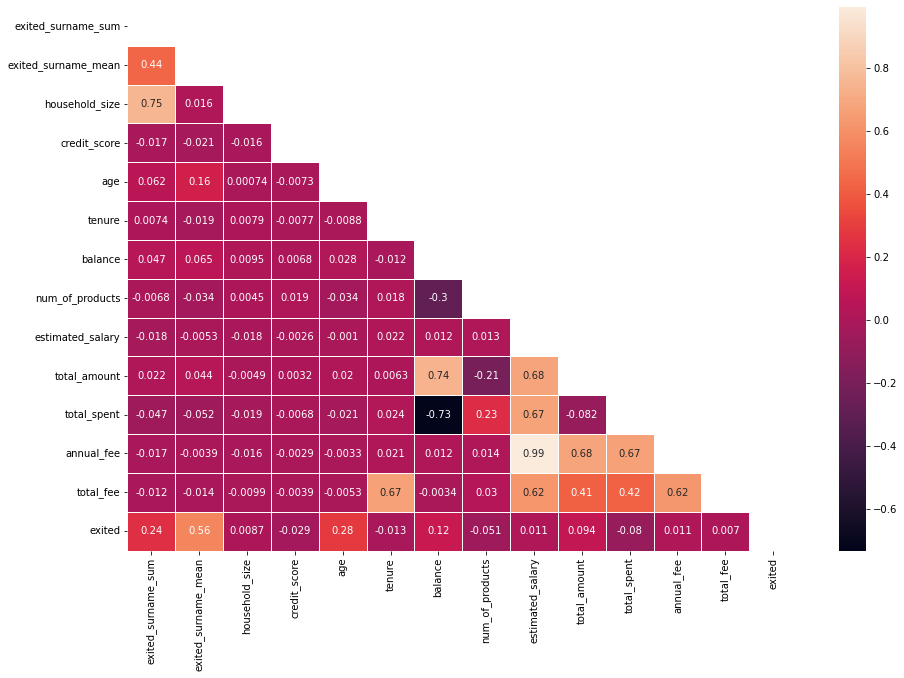

In [62]:
# calculate correlations by pearson
num_corr = num_attributes.corr(method='pearson')

# mask to only show values from below
mask = np.triu(np.ones_like(num_corr, dtype=np.bool_))

# plot heatmap
plt.figure(figsize=(15,10))
sns.heatmap(num_corr, mask=mask, linewidths=0.5, annot=True);

- **High Correlation:**
    - exited_surname_mean and exited_surname_sum -> 0.44
    - household_size and exited_surname_sum -> 0.75
    - total_amount and balance -> 0.74
    - total_amount and estimated_salary -> 0.68
    - total_spent and balance -> -0.73
    - total_spent and estimated_salary -> 0.67
    - annual_fee and estimated_salary -> 0.99
    - annual_fee and total_amount -> 0.68
    - annual_fee and total_spent -> 0.67
    - total_fee and tenure -> 0.67
    - total_fee and estimated_salary -> 0.62
    - total_fee and total_amount -> 0.41
    - total_fee and total_spent -> 0.41
    - total_fee and annual_fee -> 0.62
    
    
- **Medium Correlation:**
    - num_of_products and balance -> -0.3
    - total_amount and num_of_products -> -0.21
    - total_spent and num_of_products -> 0.23

### 4.3.2. Binary Attributes

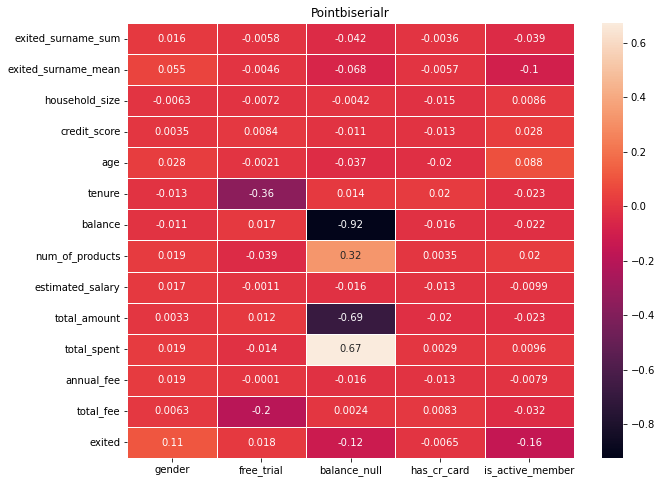

In [63]:
# numeric attributes columns
num_columns = list(num_attributes.columns)

# binary attributes columns
bin_columns = list(bin_attributes.columns)

# empty dict to store point bisserial correlations
bin_correlations = {}

for bin_col in bin_columns:
    # empty list for each binary attribute correlation 
    bin_correlations[bin_col] = []
    
    for num_col in num_columns:
        # calculate point bisserial correlations
        pb = pointbiserialr(bin_attributes[bin_col], num_attributes[num_col])
        
        # store correlation  
        bin_correlations[bin_col].append(pb[0])

# dataset of all point bisserial correlation 
pb_corr = pd.DataFrame(bin_correlations).set_index(num_attributes.columns)


# mask to only show values from below
mask = np.triu(np.ones_like(pb_corr, dtype=np.bool_))

# plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(pb_corr, linewidths=0.5, annot=True);
plt.title("Pointbiserialr");

- **High Correlation:**
    - balance and balance_null -> -0.92
    - total_amount and balance_null -> -0.69
    - total_spent and balance_null -> 0.67
    
    
- **Medium Correlation:**
    - tenure and free_trial -> -0.36
    - num_of_products and balance_null -> 0.32

### 4.3.3. Categorical Attributes

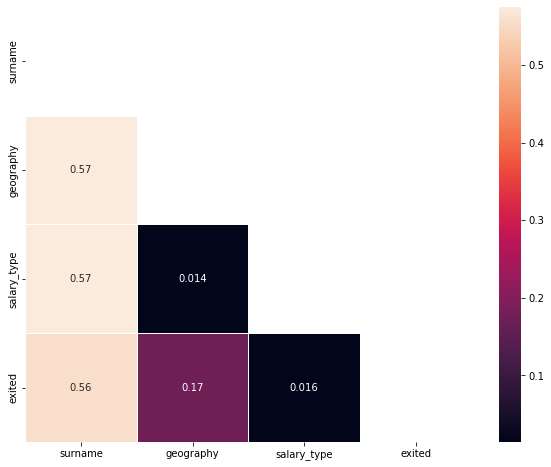

In [64]:
cat_columns = cat_attributes.columns.tolist()

corr_dict = {}

for main_cols in cat_columns:
    corr_list = []
    
    for secundary_cols in cat_columns:
        #cramer v
        cat_corr = cramer_v(cat_attributes[main_cols], cat_attributes[secundary_cols])
        
        # add to list
        corr_list.append(cat_corr)
    
    # add to dict each attribute correlation
    corr_dict[main_cols] = corr_list
    
df_corr = pd.DataFrame(corr_dict)
df_corr = df_corr.set_index(df_corr.columns)

# mask to only show values from below
mask = np.triu(np.ones_like(df_corr, dtype=np.bool_))

# plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df_corr, mask=mask, linewidths=0.5, annot=True);

- **High Correlation:**
    - geographhy and surname -> 0.57
    - salary_type and surname -> 0.57

# 5.0. Data Preparation

In [65]:
df05 = df04.copy()

## 5.1. Normalization

## 5.2. Rescaling

In [68]:
# credit score - robust scaler
rs_cred_score= RobustScaler()
df05['credit_score'] = rs_cred_score.fit_transform(df05[['credit_score']].values)

# age - robust scaler
rs_age = RobustScaler()
df05['age'] = rs_age.fit_transform(df05[['age']].values)

# tenure - minmax scaler
mms_tenure = MinMaxScaler()
df05['tenure'] = mms_tenure.fit_transform(df05[['tenure']].values)

# balance - minmax scaler
mms_balance = MinMaxScaler()
df05['balance'] = mms_balance.fit_transform(df05[['balance']].values)

# num_of_products - robust scaler
rs_nproducts = RobustScaler()
df05['num_of_products'] = rs_nproducts.fit_transform(df05[['num_of_products']].values)

# estimated_salary - minmax scaler
mms_est_salary = MinMaxScaler()
df05['estimated_salary'] = mms_est_salary.fit_transform(df05[['estimated_salary']].values)

# exited_surname_sum - robust scaler
rs_surname_sum = RobustScaler()
df05['exited_surname_sum'] = rs_surname_sum.fit_transform(df05[['exited_surname_sum']].values)

# exited_surname_mean - robust scaler
rs_surname_mean = RobustScaler()
df05['exited_surname_mean'] = rs_surname_mean.fit_transform(df05[['exited_surname_mean']].values)

# household_size - minmax scaler
mms_household = MinMaxScaler()
df05['household_size'] = mms_household.fit_transform(df05[['household_size']])

# total_amount - minmax scaler
mms_total_amount = MinMaxScaler()
df05['total_amount'] = mms_total_amount.fit_transform(df05[['total_amount']].values)

# total_spent - minmax scaler
mms_total_spent = MinMaxScaler()
df05['total_spent'] = mms_total_spent.fit_transform(df05[['total_spent']].values)

# annual_fee - minmax scaler
mms_annual_fee = MinMaxScaler()
df05['annual_fee'] = mms_annual_fee.fit_transform(df05[['annual_fee']].values)

# total_fee - robust_scaler
rs_total_fee = RobustScaler()
df05['total_fee'] = rs_total_fee.fit_transform(df05[['total_fee']].values)

## 5.3. Transformation

### 5.3.1. Encoding

In [69]:
# surname - label encoder
le_surname = LabelEncoder()
df05['surname'] = le_surname.fit_transform(df05[['surname']].values)

# geography - label encoder
le_geography = LabelEncoder()
df05['geography'] = le_geography.fit_transform(df05[['geography']].values)

# gender - binary encoder
lb_gender = LabelBinarizer()
df05['gender'] = lb_gender.fit_transform(df05[['gender']].values)

# salary_type - ordinal encoder
oe_salary = OrdinalEncoder(categories=[['low', 'medium', 'above', 'well_above']])
df05['salary_type'] = oe_salary.fit_transform(df05[['salary_type']].values)

### 5.3.2. Nature Transformation

## 5.4. Data Preparation Check

In [70]:
# display data after preparation
df05.head().T

,9254,1561,1670,6087,6669
surname,1883.000000,1379.000000,959.000000,496.000000,476.000000
exited_surname_sum,-0.500000,-0.500000,0.500000,0.500000,0.000000
exited_surname_mean,-0.606061,-0.606061,0.346320,0.227273,0.060606
household_size,0.217391,0.000000,0.260870,0.304348,0.173913
credit_score,0.246269,-0.156716,-0.701493,-0.686567,-1.014925
geography,0.000000,1.000000,2.000000,0.000000,0.000000
gender,1.000000,1.000000,1.000000,0.000000,1.000000
age,-0.416667,0.416667,-1.083333,-0.833333,1.583333
tenure,0.600000,0.400000,0.300000,0.900000,0.900000
free_trial,0.000000,0.000000,0.000000,0.000000,0.000000


# 6.0. Feature Selection

In [78]:
df06 = df05.copy()

## 6.1. Split Dataframe into Training and Validation Dataset

In [79]:
# features dataset
X = df06.drop(columns='exited')

# response dataset
y = df06['exited']

In [80]:
# split dataset into training and validation
X_train, X_val, y_train, y_val = ms.train_test_split(X, y, test_size=0.2, random_state=42)

## 6.2. Balancing

### 6.2.1. SMOTE + TOMEKLINK

In [81]:
# define sampler - over-sampling using SMOTE and cleaning using Tomek links
combine = comb.SMOTETomek(sampling_strategy='auto', random_state=32, n_jobs=-1)

# resample the dataset
X_train_comb, y_train_comb = combine.fit_resample(X_train, y_train)

In [82]:
y_train.value_counts()

0    5083
1    1317
Name: exited, dtype: int64

In [83]:
y_train_comb.value_counts()

1    5017
0    5017
Name: exited, dtype: int64

## 6.2. Manual Selection - Exploratory Data Analysis

In [84]:
# features dispensadas atraves da EDA
cols_manual_discard = ['exited_surname_sum', 'total_amount', 'surname', 'annual_fee', 'total_fee']

# manual selection for imbalanced data
X_train_manual = X_train.drop(columns=cols_manual_discard).copy()
X_val_manual = X_val.drop(columns=cols_manual_discard).copy()

# manual selection for balanced data
X_train_comb_manual = X_train_comb.drop(columns=cols_manual_discard).copy()

# 7.0. Machine Learning Model

- Metrics for Probabilistic Predictions: https://machinelearningmastery.com/probability-metrics-for-imbalanced-classification/
    
    - Log Loss: The log loss function calculates the negative log likelihood for probability predictions made by the binary classification model. **The best possible log loss is 0.0, and values are positive to infinite for progressively worse scores**.
    
    - Brier Score: Calculates the mean squared error between predicted probabilities and the expected values. It is focused on evaluating the probabilities for the positive class. **The error score is always between 0.0 and 1.0, where a model with perfect skill has a score of 0.0**.

In [85]:
# select data for machine learning models
x_train = X_train_comb_manual
x_val = X_val_manual

# select target data
y_train = y_train_comb
y_val = y_val

## 7.1. Random Forest Classifier

In [86]:
model_rf = RandomForestClassifier(random_state=42).fit(x_train, y_train)

### 7.1.1. Performance

In [87]:
# prediction in validation dataset
y_rf_pred = model_rf.predict(x_val)

# probabilistic prediction in validation dataset
y_rf_pred_proba = model_rf.predict_proba(x_val)

# select only true probabilistc
y_rf_pred_proba_true = [y_rf_pred_proba[i][1] for i in range(len(y_rf_pred_proba))]

# accuracy
acc = accuracy_score(y_val, y_rf_pred)

# precision
prec = precision_score(y_val, y_rf_pred)

# recall
recall = recall_score(y_val, y_rf_pred)

# roc_auc_score
roc_auc = roc_auc_score(y_val, y_rf_pred)

# f1 score
f1_measure = f1_score(y_val, y_rf_pred)

# logistic loss or cross-entropy loss (quanto mais proximo de 0 melhor)
avg_log_loss = log_loss(y_val, y_rf_pred_proba)

# brier score loss (range 0 - 1 , mais proximo de 1 melhor)
avg_brier_loss = brier_score_loss(y_val, y_rf_pred_proba_true)

# performance of model
performance_rf = pd.DataFrame({'model': 'Random Forest Classifier', 
                               'accuracy': acc, 
                               'precision': prec, 
                               'recall': recall,
                               'f1_score': f1_measure,
                               'roc_auc': roc_auc,  
                               'log_loss': avg_log_loss, 
                               'brier_loss': avg_brier_loss},
                              index=[0])

# display performance
performance_rf

,model,accuracy,precision,recall,f1_score,roc_auc,log_loss,brier_loss
0,Random Forest Classifier,0.895625,0.75,0.733945,0.741886,0.835551,0.285453,0.081524


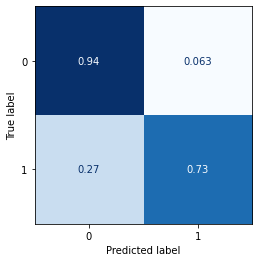

In [88]:
# confusion matrix
ConfusionMatrixDisplay.from_predictions(y_val, y_rf_pred, normalize='true', cmap='Blues', colorbar=False);

In [89]:
# check balancing of predicition
pd.DataFrame(y_rf_pred).value_counts(normalize=True)

0    0.8
1    0.2
dtype: float64